# MINECORE - TOIS replication
Implementation and replication of the experiments of the e-discovery method presented in Oard, Sebastiani, Vinjumur: "Jointly Minimizing the Expected Costs of Review for Responsiveness and Privilege in E-Discovery." https://doi.org/10.1145/3268928

## Dataset

In [1]:
from sklearn.datasets import fetch_rcv1
rcv1 = fetch_rcv1()

In [2]:
rcv1.target.shape

(804414, 103)

The paper uses only the first quarter of the test set, yet results do not differ significantly when run on the full test set.

In [3]:
TRAINING_SET_END = 23149
TEST_SET_START = TRAINING_SET_END
SMALL_TEST_SET_END = TRAINING_SET_END+199328
FULL_TEST_SET_END = rcv1.target.shape[0]
TEST_SET_END = SMALL_TEST_SET_END
TRAINING_SET_END, TEST_SET_END-TEST_SET_START

(23149, 199328)

In [4]:
import numpy as np
quarter_y_arr = dict()
for i,c in enumerate(rcv1.target_names):
    quarter_y_arr[c] = np.asarray(rcv1.target[TEST_SET_START:TEST_SET_END,i].todense()).squeeze()

In [5]:
quarter_y_arr['C11'].shape

(199328,)

In [6]:
import numpy as np
full_y_arr = dict()
for i,c in enumerate(rcv1.target_names):
    full_y_arr[c] = np.asarray(rcv1.target[0:TEST_SET_END,i].todense()).squeeze()

In [7]:
full_y_arr['C11'].shape

(222477,)

Following the paper in using the first quarter of the test set.

In [8]:
y_arr = quarter_y_arr

### Relevant r-p class pairs
These below are the class pairs tested in the paper.

In [9]:
pairs = [('M12', 'M14'), ('M12', 'CCAT'), ('M12', 'M132'), ('M12', 'E21'), ('M12', 'M131'), ('M132', 'GPOL'), 
         ('M132', 'CCAT'), ('M132', 'M12'), ('M132', 'M131'), ('M132', 'GCAT'), ('M131', 'CCAT'), ('M131', 'M132'), 
         ('M131', 'E12'), ('M131', 'ECAT'), ('M131', 'M12'), ('E12', 'M11'), ('E12', 'GDIP'), ('E12', 'E212'), 
         ('E12', 'M131'), ('E12', 'E21'), ('C21', 'C17'), ('C21', 'C15'), ('C21', 'ECAT'), ('C21', 'C31'), 
         ('C21', 'M141'), ('E212', 'GPOL'), ('E212', 'E12'), ('E212', 'M12'), ('E212', 'MCAT'), ('E212', 'C17'), 
         ('GCRIM', 'E212'), ('GCRIM', 'C15'), ('GCRIM', 'C18'), ('GCRIM', 'GDIP'), ('GCRIM', 'GPOL'), ('C24', 'GDIP'), 
         ('C24', 'C15'), ('C24', 'C31'), ('C24', 'MCAT'), ('C24', 'C21'), ('GVIO', 'C21'), ('GVIO', 'C24'), ('GVIO', 'CCAT'), 
         ('GVIO', 'ECAT'), ('GVIO', 'GCRIM'), ('C13', 'M12'), ('C13', 'C15'), ('C13', 'GPOL'), ('C13', 'M14'), ('C13', 'MCAT'), 
         ('GDIP', 'C31'), ('GDIP', 'E12'), ('GDIP', 'CCAT'), ('GDIP', 'ECAT'), ('GDIP', 'GPOL'), ('C31', 'C151'), 
         ('C31', 'C15'), ('C31', 'ECAT'), ('C31', 'C21'), ('C31', 'M14'), ('C181', 'C151'), ('C181', 'GCAT'), 
         ('C181', 'C152'), ('C181', 'C15'), ('C181', 'C17'), ('M141', 'ECAT'), ('M141', 'GCAT'), ('M141', 'C24'),
         ('M141', 'C31'), ('M141', 'C21'), ('M11', 'ECAT'), ('M11', 'C152'), ('M11', 'M132'), ('M11', 'M13'), 
         ('M11', 'CCAT'), ('E21', 'C31'), ('E21', 'M12'), ('E21', 'MCAT'), ('E21', 'E12'), ('E21', 'GPOL'), 
         ('C17', 'MCAT'), ('C17', 'C152'), ('C17', 'C15'), ('C17', 'C18'), ('C17', 'ECAT'), ('M13', 'E21'), 
         ('M13', 'M11'), ('M13', 'GCAT'), ('M13', 'E12'), ('M13', 'ECAT'), ('C18', 'E12'), ('C18', 'GCAT'), 
         ('C18', 'C152'), ('C18', 'C15'), ('C18', 'C17'), ('GPOL', 'MCAT'), ('GPOL', 'CCAT'), ('GPOL', 'GCRIM'), 
         ('GPOL', 'E21'), ('GPOL', 'GVIO'), ('C152', 'M11'), ('C152', 'C17'), ('C152', 'C31'), ('C152', 'C181'), 
         ('C152', 'C18'), ('M14', 'M132'), ('M14', 'M13'), ('M14', 'GCAT'), ('M14', 'C24'), ('M14', 'C31'), ('C151', 'C181'), 
         ('C151', 'C18'), ('C151', 'C17'), ('C151', 'C31'), ('C151', 'C152'), ('ECAT', 'GVIO'), ('ECAT', 'C17'), 
         ('ECAT', 'M13'), ('ECAT', 'GPOL'), ('ECAT', 'MCAT')]

## Timining utils

In [10]:
import time
import re

_timer_curr_name = None
_timer_curr_start = 0
_timers = dict()

def timer(name=None):
    global _timer_curr_name,_timer_curr_start,_timers
    now = time.time()
    if _timer_curr_name:
        _timers[_timer_curr_name] = now-_timer_curr_start
    _timer_curr_start = now
    _timer_curr_name = name
    
def dump_timers(regex='.*'):
    global _timers
    for key in _timers:
        if re.fullmatch(regex,key):
            print(key, f'{_timers[key]:9.3f}')
            
def del_timer(name):
    try:
        del _timers[name]
    except:
        pass

## Classifiers
Differently from the paper I use sklearn. Results are not significantly different.

In [11]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

In [12]:
kfold = 10

In [13]:
labels = set()
for cr,cp in pairs:
    labels.add(cr)
    labels.add(cp)
labels

{'C13',
 'C15',
 'C151',
 'C152',
 'C17',
 'C18',
 'C181',
 'C21',
 'C24',
 'C31',
 'CCAT',
 'E12',
 'E21',
 'E212',
 'ECAT',
 'GCAT',
 'GCRIM',
 'GDIP',
 'GPOL',
 'GVIO',
 'M11',
 'M12',
 'M13',
 'M131',
 'M132',
 'M14',
 'M141',
 'MCAT'}

In [14]:
classifiers = dict()
train_X = rcv1.data[0:TRAINING_SET_END]
for label in labels:
    timer('learn '+label)
    label_idx = rcv1.target_names.tolist().index(label)
    learner = LinearSVC(loss='hinge')
    train_y = np.asarray(rcv1.target[0:TRAINING_SET_END,[label_idx]].todense()).squeeze()
    print(label, label_idx,train_y.sum())
    label_kfold = min(train_y.sum(),kfold)
    calibrator = CalibratedClassifierCV(learner,cv=label_kfold, method='sigmoid')
    classifiers[label] = calibrator.fit(train_X,train_y)
timer()

GDIP 73 1004
C13 2 947


GVIO 89 1115


ECAT 59 3449


E212 46 853


MCAT 102 5882


C31 22 1058


M131 96 943


M13 95 1596


M132 97 699


M14 98 2541


C18 14 1462


M141 99 1508


GCRIM 71 1133


C181 15 1205


C21 18 793


GPOL 83 1647


C152 7 1930


C151 5 2366


E12 35 679


GCAT 70 6970


CCAT 33 10786


M12 94 732


E21 44 1255


C17 9 1172


C24 21 922


C15 4 4179


M11 93 1294


In [15]:
dump_timers()

learn GDIP     3.729
learn C13     8.203
learn GVIO     4.126
learn ECAT    10.557
learn E212     3.348
learn MCAT     8.972
learn C31     6.968
learn M131     3.265
learn M13     4.579
learn M132     3.794
learn M14     5.714
learn C18     5.865
learn M141     4.425
learn GCRIM     5.199
learn C181     4.967
learn C21     6.677
learn GPOL     7.526
learn C152     7.157
learn C151     4.648
learn E12     5.631
learn GCAT    11.099
learn CCAT    13.895
learn M12     3.446
learn E21     3.552
learn C17     5.280
learn C24     3.987
learn C15     7.994
learn M11     4.608


In [16]:
import pickle

In [17]:
with open('classifiers_TOIS.pkl',mode='wb') as outputfile:
    pickle.dump(classifiers,outputfile)

In [18]:
posterior_probabilities = dict()
test_X = rcv1.data[TEST_SET_START:TEST_SET_END,:]
for label in labels:
    timer('classify '+label)
    label_idx = rcv1.target_names.tolist().index(label)
    print(label,label_idx)
    clf = classifiers[label]
    proba = clf.predict_proba(test_X)
    posterior_probabilities[label] = proba
timer()

GDIP 73
C13 2
GVIO 89
ECAT 59
E212 46
MCAT 102
C31 22
M131 96
M13 95
M132 97
M14 98
C18 14
M141 99
GCRIM 71
C181 15
C21 18
GPOL 83
C152 7
C151 5
E12 35
GCAT 70
CCAT 33
M12 94
E21 44
C17 9
C24 21
C15 4
M11 93


In [19]:
with open('times_TOIS.pkl', mode='wb') as outputfile:
    pickle.dump(_timers,outputfile)

In [20]:
with open('posterior_probabilities_TOIS.pkl',mode='wb') as outputfile:
    pickle.dump(posterior_probabilities,outputfile)

In [21]:
import pickle
with open('times_TOIS.pkl',mode='rb') as inputfile:
    _timers = pickle.load(inputfile)
with open('classifiers_TOIS.pkl',mode='rb') as inputfile:
    classifiers = pickle.load(inputfile)
with open('posterior_probabilities_TOIS.pkl',mode='rb') as inputfile:
    posterior_probabilities = pickle.load(inputfile)

## evaluation of classifiers

In [22]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

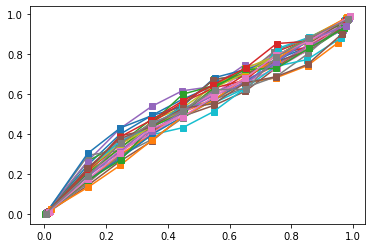

In [23]:
for label in labels:
    label_idx = rcv1.target_names.tolist().index(label)
    fraction_of_positives, mean_predicted_value = calibration_curve(np.asarray(rcv1.target[TEST_SET_START:TEST_SET_END,[label_idx]].todense()).squeeze(),posterior_probabilities[label][:,1],n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-")

In [24]:
gtp = 0
gtn = 0
gfp = 0
gfn = 0
f1_values = list()
accu_values = list()
for label in labels:
    label_idx = rcv1.target_names.tolist().index(label)
    evaluation = ((np.asarray(rcv1.target[TRAINING_SET_END:TEST_SET_END,[label_idx]].todense()).squeeze()*2)+(posterior_probabilities[label][:,1]>0.5))
    tp = (evaluation==3).sum()
    tn = (evaluation==0).sum()
    fp = (evaluation==1).sum()
    fn = (evaluation==2).sum()
    gtp += tp
    gtn += tn
    gfp += fp
    gfn += fn
    accu_values.append((tp+tn)/(tp+tn+fp+fn))
    f1_values.append((2*tp)/(2*tp+fp+fn))
    print(label, tp,tn,fp,fn, (tp+tn)/(tp+tn+fp+fn),(2*tp)/(2*tp+fp+fn))

print('macro',np.mean(accu_values),np.mean(f1_values))
print("micro", gtp,gtn,gfp,gfn, (gtp+gtn)/(gtp+gtn+gfp+gfn),(2*gtp)/(2*gtp+gfp+gfn))

GDIP 6077 188072 1287 3892 0.97401769947022 0.701205792419085
C13 2607 188726 1117 6878 0.9598902311767539 0.3947308653191006
GVIO 5404 189673 1142 3109 0.9786733424305667 0.7177103393319609
ECAT 22125 166143 2849 8211 0.9445135655803499 0.8000361598264328
E212 5100 191742 340 2146 0.9875280943971745 0.8040359451363708
MCAT 41365 150520 2979 4464 0.9626595360410981 0.917458662792632
C31 3181 187926 890 7331 0.958756421576497 0.43626140026057736
M131 5054 192549 349 1376 0.9913459222989244 0.8542212456688921
M13 9827 186602 647 2252 0.9854561326055546 0.8714583425708331
M132 4678 192880 516 1254 0.9911201637502006 0.8409131763436994
M14 17521 178600 1109 2098 0.9839109407609569 0.9161546707103454
C18 9467 184598 1774 3489 0.9735962835126023 0.782493697565814
M141 9968 187856 770 734 0.9924546476159897 0.9298507462686567
GCRIM 5212 190924 840 2352 0.9839861936105314 0.7655699177438308
C181 7247 187128 1548 3405 0.9751515090704768 0.7453077595516018
C21 2364 191682 505 4777 0.973500963236

## Cost structures

In [25]:
cost_structures = [{
    'cost_r': 1.,
    'cost_p': 5.,
    'cost_PP' : 0.,
    'cost_PL' : 600.,
    'cost_PW' : 5.,
    'cost_LP' : 150.,
    'cost_LL' : 0.,
    'cost_LW' : 3.,
    'cost_WP' : 15.,
    'cost_WL' : 15.,
    'cost_WW' : 0.,},
    {
    'cost_r': 1.,
    'cost_p': 5.,
    'cost_PP' : 0.,
    'cost_PL' : 100.,
    'cost_PW' : 0.03,
    'cost_LP' : 10.,
    'cost_LL' : 0.,
    'cost_LW' : 2.,
    'cost_WP' : 8.,
    'cost_WL' : 8.,
    'cost_WW' : 0.,},
    {
    'cost_r': 1.,
    'cost_p': 5.,
    'cost_PP' : 0.,
    'cost_PL' : 1000.,
    'cost_PW' : 0.1,
    'cost_LP' : 1.,
    'cost_LL' : 0.,
    'cost_LW' : 1.,
    'cost_WP' : 1.,
    'cost_WL' : 1.,
    'cost_WW' : 0.,},]

Select a cost structure and run all the cells below to complete the experiments for that cost structure

In [26]:
selected_cost_structure = 0

In [27]:
cost_r = cost_structures[selected_cost_structure]['cost_r']
cost_p = cost_structures[selected_cost_structure]['cost_p']
cost_PP = cost_structures[selected_cost_structure]['cost_PP']
cost_PL = cost_structures[selected_cost_structure]['cost_PL']
cost_PW = cost_structures[selected_cost_structure]['cost_PW']
cost_LP = cost_structures[selected_cost_structure]['cost_LP']
cost_LL = cost_structures[selected_cost_structure]['cost_LL']
cost_LW = cost_structures[selected_cost_structure]['cost_LW']
cost_WP = cost_structures[selected_cost_structure]['cost_WP']
cost_WL = cost_structures[selected_cost_structure]['cost_WL']
cost_WW = cost_structures[selected_cost_structure]['cost_WW']

In [28]:
label_to_idx = {'P':0,'L':1,'W':2}
cost_matrix = {'P':{'P':cost_PP,'L':cost_PL,'W':cost_PW},
        'L':{'P':cost_LP,'L':cost_LL,'W':cost_LW},
        'W':{'P':cost_WP,'L':cost_WL,'W':cost_WW},}

## Manual Method

In [29]:
cost_manual = dict()
cost_manual_ann = dict()
cost_manual_misc = dict()
for c_r,c_p in pairs:
    timer(' '.join(['FM',c_r,c_p]))
    cost_ann = cost_r*(TEST_SET_END-TEST_SET_START)+cost_p*y_arr[c_r].sum()
    cost_misc = 0.0
    cost_manual_ann[(c_r,c_p)] = cost_ann
    cost_manual_misc[(c_r,c_p)] = cost_misc
    cost_manual[(c_r,c_p)] = cost_ann+cost_misc    
timer()
list(zip(cost_manual,cost_manual_ann.values(),cost_manual_misc.values(),cost_manual.values()))

[(('M12', 'M14'), 226493.0, 0.0, 226493.0),
 (('M12', 'CCAT'), 226493.0, 0.0, 226493.0),
 (('M12', 'M132'), 226493.0, 0.0, 226493.0),
 (('M12', 'E21'), 226493.0, 0.0, 226493.0),
 (('M12', 'M131'), 226493.0, 0.0, 226493.0),
 (('M132', 'GPOL'), 228988.0, 0.0, 228988.0),
 (('M132', 'CCAT'), 228988.0, 0.0, 228988.0),
 (('M132', 'M12'), 228988.0, 0.0, 228988.0),
 (('M132', 'M131'), 228988.0, 0.0, 228988.0),
 (('M132', 'GCAT'), 228988.0, 0.0, 228988.0),
 (('M131', 'CCAT'), 231478.0, 0.0, 231478.0),
 (('M131', 'M132'), 231478.0, 0.0, 231478.0),
 (('M131', 'E12'), 231478.0, 0.0, 231478.0),
 (('M131', 'ECAT'), 231478.0, 0.0, 231478.0),
 (('M131', 'M12'), 231478.0, 0.0, 231478.0),
 (('E12', 'M11'), 232163.0, 0.0, 232163.0),
 (('E12', 'GDIP'), 232163.0, 0.0, 232163.0),
 (('E12', 'E212'), 232163.0, 0.0, 232163.0),
 (('E12', 'M131'), 232163.0, 0.0, 232163.0),
 (('E12', 'E21'), 232163.0, 0.0, 232163.0),
 (('C21', 'C17'), 235033.0, 0.0, 235033.0),
 (('C21', 'C15'), 235033.0, 0.0, 235033.0),
 (('C21',

In [30]:
manual_labels = dict()
for c_r,c_p in pairs:
    print(c_r,c_p)
    
    y_r = y_arr[c_r]
    y_p = y_arr[c_p]
    y = np.zeros(y_p.shape,dtype=int)
    y[y_r==0]=label_to_idx['W']
    y[np.logical_and(y_r==1,y_p==1)]=label_to_idx['L']
    y[np.logical_and(y_r==1,y_p==0)]=label_to_idx['P']
    manual_labels[(c_r,c_p)] = y

M12 M14
M12 CCAT
M12 M132
M12 E21
M12 M131
M132 GPOL
M132 CCAT
M132 M12
M132 M131
M132 GCAT
M131 CCAT
M131 M132
M131 E12
M131 ECAT
M131 M12
E12 M11
E12 GDIP
E12 E212
E12 M131
E12 E21
C21 C17
C21 C15
C21 ECAT
C21 C31
C21 M141
E212 GPOL
E212 E12
E212 M12
E212 MCAT
E212 C17
GCRIM E212
GCRIM C15
GCRIM C18
GCRIM GDIP
GCRIM GPOL
C24 GDIP
C24 C15
C24 C31
C24 MCAT
C24 C21
GVIO C21
GVIO C24
GVIO CCAT
GVIO ECAT
GVIO GCRIM
C13 M12
C13 C15
C13 GPOL
C13 M14
C13 MCAT
GDIP C31
GDIP E12
GDIP CCAT
GDIP ECAT
GDIP GPOL
C31 C151
C31 C15
C31 ECAT
C31 C21
C31 M14
C181 C151
C181 GCAT
C181 C152
C181 C15
C181 C17
M141 ECAT
M141 GCAT
M141 C24
M141 C31
M141 C21
M11 ECAT
M11 C152
M11 M132
M11 M13
M11 CCAT
E21 C31
E21 M12
E21 MCAT
E21 E12
E21 GPOL
C17 MCAT
C17 C152
C17 C15
C17 C18
C17 ECAT
M13 E21
M13 M11
M13 GCAT
M13 E12
M13 ECAT
C18 E12
C18 GCAT
C18 C152
C18 C15
C18 C17
GPOL MCAT
GPOL CCAT
GPOL GCRIM
GPOL E21
GPOL GVIO
C152 M11
C152 C17
C152 C31
C152 C181
C152 C18
M14 M132
M14 M13
M14 GCAT
M14 C24
M14 C31
C151 C

## Fully Automated Method

In [31]:
def get_h_risk_h(c_r_prob, c_p_prob, cost_matrix, need_risk=True):
    c_P_prob = c_r_prob*(1-c_p_prob)
    c_L_prob = c_r_prob*c_p_prob
    c_W_prob = 1-c_r_prob

    risk_P = cost_matrix['P']['P']*c_P_prob+cost_matrix['P']['L']*c_L_prob+cost_matrix['P']['W']*c_W_prob
    risk_L = cost_matrix['L']['P']*c_P_prob+cost_matrix['L']['L']*c_L_prob+cost_matrix['L']['W']*c_W_prob
    risk_W = cost_matrix['W']['P']*c_P_prob+cost_matrix['W']['L']*c_L_prob+cost_matrix['W']['W']*c_W_prob

    # NOTE: the order of the following vstack must follow the label_to_idx mapping
    risks = np.vstack((risk_P,risk_L,risk_W)).T
    h = risks.argmin(1)
    if need_risk:
        risk_h = np.asarray([risks[i,h[i]] for i in range(h.shape[0])])
    else:
        risk_h = None
    return h,risk_h

In [32]:
from sklearn.metrics import confusion_matrix
cm_auto = dict()
for c_r,c_p in pairs:
    print(c_r,c_p)
    timer(' '.join(['FA',c_r,c_p]))
    c_r_probs = posterior_probabilities[c_r]
    c_p_probs = posterior_probabilities[c_p]
    
    h = get_h_risk_h(c_r_probs[:,1], c_p_probs[:,1], cost_matrix, need_risk=False)[0]
    
    cm_auto[(c_r,c_p)] = confusion_matrix(manual_labels[(c_r,c_p)],h)
timer()

M12 M14
M12 CCAT
M12 M132
M12 E21
M12 M131
M132 GPOL
M132 CCAT
M132 M12
M132 M131
M132 GCAT
M131 CCAT
M131 M132
M131 E12
M131 ECAT
M131 M12
E12 M11
E12 GDIP
E12 E212
E12 M131
E12 E21
C21 C17
C21 C15
C21 ECAT
C21 C31
C21 M141
E212 GPOL
E212 E12
E212 M12
E212 MCAT
E212 C17
GCRIM E212
GCRIM C15
GCRIM C18
GCRIM GDIP
GCRIM GPOL
C24 GDIP
C24 C15
C24 C31
C24 MCAT
C24 C21
GVIO C21
GVIO C24
GVIO CCAT
GVIO ECAT
GVIO GCRIM
C13 M12
C13 C15
C13 GPOL
C13 M14
C13 MCAT
GDIP C31
GDIP E12
GDIP CCAT
GDIP ECAT
GDIP GPOL
C31 C151
C31 C15
C31 ECAT
C31 C21
C31 M14
C181 C151
C181 GCAT
C181 C152
C181 C15
C181 C17
M141 ECAT
M141 GCAT
M141 C24
M141 C31
M141 C21
M11 ECAT
M11 C152
M11 M132
M11 M13
M11 CCAT
E21 C31
E21 M12
E21 MCAT
E21 E12
E21 GPOL
C17 MCAT
C17 C152
C17 C15
C17 C18
C17 ECAT
M13 E21
M13 M11
M13 GCAT
M13 E12
M13 ECAT
C18 E12
C18 GCAT
C18 C152
C18 C15
C18 C17
GPOL MCAT
GPOL CCAT
GPOL GCRIM
GPOL E21
GPOL GVIO
C152 M11
C152 C17
C152 C31
C152 C181
C152 C18
M14 M132
M14 M13
M14 GCAT
M14 C24
M14 C31
C151 C

In [33]:
cost_auto = dict()
cost_auto_ann = dict()
cost_auto_misc = dict()
for c_r,c_p in pairs:
    cm = cm_auto[(c_r,c_p)]
    cost_misc = 0.0
    for true_label in label_to_idx.keys():
        for pred_label in label_to_idx.keys():
            cost_misc += cost_matrix[true_label][pred_label]*cm[label_to_idx[pred_label],label_to_idx[true_label]]
    cost_ann = 0.0
    cost_auto_ann[(c_r,c_p)] = cost_ann
    cost_auto_misc[(c_r,c_p)] = cost_misc
    cost_auto[(c_r,c_p)] = cost_ann+cost_misc
list(zip(cost_auto,cost_auto_ann.values(),cost_auto_misc.values(),cost_auto.values()))

[(('M12', 'M14'), 0.0, 26075.0, 26075.0),
 (('M12', 'CCAT'), 0.0, 46491.0, 46491.0),
 (('M12', 'M132'), 0.0, 52419.0, 52419.0),
 (('M12', 'E21'), 0.0, 70517.0, 70517.0),
 (('M12', 'M131'), 0.0, 175097.0, 175097.0),
 (('M132', 'GPOL'), 0.0, 30758.0, 30758.0),
 (('M132', 'CCAT'), 0.0, 44360.0, 44360.0),
 (('M132', 'M12'), 0.0, 36926.0, 36926.0),
 (('M132', 'M131'), 0.0, 64651.0, 64651.0),
 (('M132', 'GCAT'), 0.0, 39854.0, 39854.0),
 (('M131', 'CCAT'), 0.0, 56818.0, 56818.0),
 (('M131', 'M132'), 0.0, 50169.0, 50169.0),
 (('M131', 'E12'), 0.0, 84698.0, 84698.0),
 (('M131', 'ECAT'), 0.0, 91846.0, 91846.0),
 (('M131', 'M12'), 0.0, 73386.0, 73386.0),
 (('E12', 'M11'), 0.0, 55694.0, 55694.0),
 (('E12', 'GDIP'), 0.0, 75425.0, 75425.0),
 (('E12', 'E212'), 0.0, 72265.0, 72265.0),
 (('E12', 'M131'), 0.0, 86500.0, 86500.0),
 (('E12', 'E21'), 0.0, 91993.0, 91993.0),
 (('C21', 'C17'), 0.0, 76959.0, 76959.0),
 (('C21', 'C15'), 0.0, 83158.0, 83158.0),
 (('C21', 'ECAT'), 0.0, 90665.0, 90665.0),
 (('C21'

## Hybrid Method

In [34]:
tau_rs = dict()
tau_ps = dict()
cm_2 = dict()
cm_3 = dict()
for c_r,c_p in pairs:
    print(c_r,c_p)
    timer(' '.join(['RM',c_r,c_p]))
    c_r_probs = posterior_probabilities[c_r]
    c_p_probs = posterior_probabilities[c_p]

    # phase one - automatic step
    risk_h_auto = get_h_risk_h(c_r_probs[:,1], c_p_probs[:,1], cost_matrix, need_risk=True)[1]

    # phase two - responsiveness
    # cr case
    risk_h_2_cr = get_h_risk_h(np.ones_like(c_r_probs[:,1]),c_p_probs[:,1],cost_matrix, need_risk=True)[1]

    # ncr case
    risk_h_2_ncr = get_h_risk_h(np.zeros_like(c_r_probs[:,1]),c_p_probs[:,1],cost_matrix, need_risk=True)[1]

    # expected risk
    e_risk_h_2 = risk_h_2_cr*c_r_probs[:,1]+ risk_h_2_ncr*c_r_probs[:,0]
    
    delta_or = e_risk_h_2 + np.ones(c_r_probs[:,0].shape)*cost_r - risk_h_auto
    
    tau_rs[(c_r,c_p)] = (delta_or<0).sum()
    
    c_r_probs_2 = np.copy(c_r_probs[:,1])

    y_r = y_arr[c_r]
    c_r_probs_2[np.logical_and(delta_or<0,y_r==1)] = 1
    c_r_probs_2[np.logical_and(delta_or<0,y_r==0)] = 0
    
    h_2, risk_h_2 = get_h_risk_h(c_r_probs_2,c_p_probs[:,1],cost_matrix, need_risk=True)

    cm_2[(c_r,c_p)] = confusion_matrix(manual_labels[(c_r,c_p)],h_2)
    
    # phase three - privilege
    # cp case
    risk_h_3_cp = get_h_risk_h(c_r_probs_2,np.ones_like(c_p_probs[:,1]),cost_matrix, need_risk=True)[1]

    # ncp case
    risk_h_3_ncp = get_h_risk_h(c_r_probs_2,np.zeros_like(c_p_probs[:,1]),cost_matrix, need_risk=True)[1]

    # expected risk
    e_risk_h_3 = risk_h_3_cp*c_p_probs[:,1]+ risk_h_3_ncp*c_p_probs[:,0]
        
    delta_op = e_risk_h_3 + np.ones(c_p_probs[:,0].shape)*cost_p - risk_h_2
    
    tau_ps[(c_r,c_p)] = (delta_op<0).sum()
    
    c_p_probs_3 = np.copy(c_p_probs[:,1])

    y_p = y_arr[c_p]
    c_p_probs_3[np.logical_and(delta_op<0,y_p==1)] = 1
    c_p_probs_3[np.logical_and(delta_op<0,y_p==0)] = 0
    
    h_3 = get_h_risk_h(c_r_probs_2,c_p_probs_3,cost_matrix, need_risk=False)[0]
    cm_3[(c_r,c_p)] = confusion_matrix(manual_labels[(c_r,c_p)],h_3)

timer()
    

M12 M14
M12 CCAT
M12 M132
M12 E21
M12 M131
M132 GPOL
M132 CCAT
M132 M12
M132 M131
M132 GCAT
M131 CCAT
M131 M132
M131 E12
M131 ECAT
M131 M12
E12 M11
E12 GDIP
E12 E212
E12 M131
E12 E21
C21 C17
C21 C15
C21 ECAT
C21 C31
C21 M141
E212 GPOL
E212 E12
E212 M12
E212 MCAT
E212 C17
GCRIM E212
GCRIM C15
GCRIM C18
GCRIM GDIP
GCRIM GPOL
C24 GDIP
C24 C15
C24 C31
C24 MCAT
C24 C21
GVIO C21
GVIO C24
GVIO CCAT
GVIO ECAT
GVIO GCRIM
C13 M12
C13 C15
C13 GPOL
C13 M14
C13 MCAT
GDIP C31
GDIP E12
GDIP CCAT
GDIP ECAT
GDIP GPOL
C31 C151
C31 C15
C31 ECAT
C31 C21
C31 M14
C181 C151
C181 GCAT
C181 C152
C181 C15
C181 C17
M141 ECAT
M141 GCAT
M141 C24
M141 C31
M141 C21
M11 ECAT
M11 C152
M11 M132
M11 M13
M11 CCAT
E21 C31
E21 M12
E21 MCAT
E21 E12
E21 GPOL
C17 MCAT
C17 C152
C17 C15
C17 C18
C17 ECAT
M13 E21
M13 M11
M13 GCAT
M13 E12
M13 ECAT
C18 E12
C18 GCAT
C18 C152
C18 C15
C18 C17
GPOL MCAT
GPOL CCAT
GPOL GCRIM
GPOL E21
GPOL GVIO
C152 M11
C152 C17
C152 C31
C152 C181
C152 C18
M14 M132
M14 M13
M14 GCAT
M14 C24
M14 C31
C151 C

In [35]:
tau_rs

{('M12', 'M14'): 3527,
 ('M12', 'CCAT'): 1896,
 ('M12', 'M132'): 3078,
 ('M12', 'E21'): 2346,
 ('M12', 'M131'): 2922,
 ('M132', 'GPOL'): 2587,
 ('M132', 'CCAT'): 2109,
 ('M132', 'M12'): 2747,
 ('M132', 'M131'): 2889,
 ('M132', 'GCAT'): 2638,
 ('M131', 'CCAT'): 1284,
 ('M131', 'M132'): 1817,
 ('M131', 'E12'): 1384,
 ('M131', 'ECAT'): 852,
 ('M131', 'M12'): 1592,
 ('E12', 'M11'): 8673,
 ('E12', 'GDIP'): 7358,
 ('E12', 'E212'): 7546,
 ('E12', 'M131'): 7607,
 ('E12', 'E21'): 5474,
 ('C21', 'C17'): 6123,
 ('C21', 'C15'): 4825,
 ('C21', 'ECAT'): 3484,
 ('C21', 'C31'): 1877,
 ('C21', 'M141'): 7597,
 ('E212', 'GPOL'): 2428,
 ('E212', 'E12'): 2415,
 ('E212', 'M12'): 2318,
 ('E212', 'MCAT'): 2002,
 ('E212', 'C17'): 1781,
 ('GCRIM', 'E212'): 6581,
 ('GCRIM', 'C15'): 5036,
 ('GCRIM', 'C18'): 5415,
 ('GCRIM', 'GDIP'): 4118,
 ('GCRIM', 'GPOL'): 2336,
 ('C24', 'GDIP'): 9378,
 ('C24', 'C15'): 6541,
 ('C24', 'C31'): 3853,
 ('C24', 'MCAT'): 7081,
 ('C24', 'C21'): 3193,
 ('GVIO', 'C21'): 5387,
 ('GVIO', 

In [36]:
cost_2 = dict()
cost_2_ann = dict()
cost_2_misc = dict()
for c_r,c_p in pairs:
    cm = cm_2[(c_r,c_p)]
    cost_misc = 0.0
    for true_label in label_to_idx.keys():
        for pred_label in label_to_idx.keys():
            cost_misc += cost_matrix[true_label][pred_label]*cm[label_to_idx[pred_label],label_to_idx[true_label]]
    cost_ann = tau_rs[(c_r,c_p)]*cost_r
    cost_2_ann[(c_r,c_p)] = cost_ann
    cost_2_misc[(c_r,c_p)] = cost_misc
    cost_2[(c_r,c_p)] = cost_ann+cost_misc   
list(zip(cost_2,cost_2_ann.values(),cost_2_misc.values(),cost_2.values()))

[(('M12', 'M14'), 3527.0, 19470.0, 22997.0),
 (('M12', 'CCAT'), 1896.0, 46475.0, 48371.0),
 (('M12', 'M132'), 3078.0, 48777.0, 51855.0),
 (('M12', 'E21'), 2346.0, 69632.0, 71978.0),
 (('M12', 'M131'), 2922.0, 185890.0, 188812.0),
 (('M132', 'GPOL'), 2587.0, 24532.0, 27119.0),
 (('M132', 'CCAT'), 2109.0, 40999.0, 43108.0),
 (('M132', 'M12'), 2747.0, 32177.0, 34924.0),
 (('M132', 'M131'), 2889.0, 67026.0, 69915.0),
 (('M132', 'GCAT'), 2638.0, 35148.0, 37786.0),
 (('M131', 'CCAT'), 1284.0, 54509.0, 55793.0),
 (('M131', 'M132'), 1817.0, 53801.0, 55618.0),
 (('M131', 'E12'), 1384.0, 82094.0, 83478.0),
 (('M131', 'ECAT'), 852.0, 89970.0, 90822.0),
 (('M131', 'M12'), 1592.0, 72400.0, 73992.0),
 (('E12', 'M11'), 8673.0, 31508.0, 40181.0),
 (('E12', 'GDIP'), 7358.0, 59165.0, 66523.0),
 (('E12', 'E212'), 7546.0, 56050.0, 63596.0),
 (('E12', 'M131'), 7607.0, 68476.0, 76083.0),
 (('E12', 'E21'), 5474.0, 83517.0, 88991.0),
 (('C21', 'C17'), 6123.0, 59635.0, 65758.0),
 (('C21', 'C15'), 4825.0, 70410

In [37]:
tau_ps

{('M12', 'M14'): 1207,
 ('M12', 'CCAT'): 2358,
 ('M12', 'M132'): 1417,
 ('M12', 'E21'): 2459,
 ('M12', 'M131'): 1881,
 ('M132', 'GPOL'): 1523,
 ('M132', 'CCAT'): 2552,
 ('M132', 'M12'): 2348,
 ('M132', 'M131'): 2056,
 ('M132', 'GCAT'): 1673,
 ('M131', 'CCAT'): 3172,
 ('M131', 'M132'): 1840,
 ('M131', 'E12'): 2547,
 ('M131', 'ECAT'): 3864,
 ('M131', 'M12'): 2354,
 ('E12', 'M11'): 521,
 ('E12', 'GDIP'): 1170,
 ('E12', 'E212'): 1431,
 ('E12', 'M131'): 1691,
 ('E12', 'E21'): 2070,
 ('C21', 'C17'): 1255,
 ('C21', 'C15'): 1764,
 ('C21', 'ECAT'): 2099,
 ('C21', 'C31'): 2471,
 ('C21', 'M141'): 1178,
 ('E212', 'GPOL'): 3731,
 ('E212', 'E12'): 2016,
 ('E212', 'M12'): 2129,
 ('E212', 'MCAT'): 3688,
 ('E212', 'C17'): 2973,
 ('GCRIM', 'E212'): 1066,
 ('GCRIM', 'C15'): 3093,
 ('GCRIM', 'C18'): 1973,
 ('GCRIM', 'GDIP'): 3017,
 ('GCRIM', 'GPOL'): 5351,
 ('C24', 'GDIP'): 1587,
 ('C24', 'C15'): 2963,
 ('C24', 'C31'): 3912,
 ('C24', 'MCAT'): 2497,
 ('C24', 'C21'): 4264,
 ('GVIO', 'C21'): 4895,
 ('GVIO', 

In [38]:
cost_3 = dict()
cost_3_ann = dict()
cost_3_misc = dict()
for c_r,c_p in pairs:
    cm = cm_3[(c_r,c_p)]
    cost_misc = 0.0
    for true_label in label_to_idx.keys():
        for pred_label in label_to_idx.keys():
            cost_misc += cost_matrix[true_label][pred_label]*cm[label_to_idx[pred_label],label_to_idx[true_label]]
    cost_ann = tau_rs[(c_r,c_p)]*cost_r+tau_ps[(c_r,c_p)]*cost_p
    cost_3_ann[(c_r,c_p)] = cost_ann
    cost_3_misc[(c_r,c_p)] = cost_misc
    cost_3[(c_r,c_p)] = cost_ann+cost_misc   
list(zip(cost_3,cost_3_ann.values(),cost_3_misc.values(),cost_3.values()))

[(('M12', 'M14'), 9562.0, 13812.0, 23374.0),
 (('M12', 'CCAT'), 13686.0, 20834.0, 34520.0),
 (('M12', 'M132'), 10163.0, 27793.0, 37956.0),
 (('M12', 'E21'), 14641.0, 29730.0, 44371.0),
 (('M12', 'M131'), 12327.0, 116456.0, 128783.0),
 (('M132', 'GPOL'), 10202.0, 13226.0, 23428.0),
 (('M132', 'CCAT'), 14869.0, 18227.0, 33096.0),
 (('M132', 'M12'), 14487.0, 17109.0, 31596.0),
 (('M132', 'M131'), 13169.0, 35835.0, 49004.0),
 (('M132', 'GCAT'), 11003.0, 18939.0, 29942.0),
 (('M131', 'CCAT'), 17144.0, 23209.0, 40353.0),
 (('M131', 'M132'), 11017.0, 27784.0, 38801.0),
 (('M131', 'E12'), 14119.0, 38194.0, 52313.0),
 (('M131', 'ECAT'), 20172.0, 32376.0, 52548.0),
 (('M131', 'M12'), 13362.0, 38586.0, 51948.0),
 (('E12', 'M11'), 11278.0, 30086.0, 41364.0),
 (('E12', 'GDIP'), 13208.0, 48571.0, 61779.0),
 (('E12', 'E212'), 14701.0, 40356.0, 55057.0),
 (('E12', 'M131'), 16062.0, 45986.0, 62048.0),
 (('E12', 'E21'), 15824.0, 52885.0, 68709.0),
 (('C21', 'C17'), 12398.0, 52598.0, 64996.0),
 (('C21', 

## Uncertainty Ranking

In [39]:
from sklearn.metrics import confusion_matrix
cm_ur = dict()
for c_r,c_p in pairs:
    print(c_r,c_p)
    timer(' '.join(['UR',c_r,c_p]))
    c_r_probs = posterior_probabilities[c_r]
    c_p_probs = posterior_probabilities[c_p]
    
    uncertainty_c_r = np.abs(c_r_probs[:,1]-0.5)
    u_r_idxs = np.argsort(uncertainty_c_r)[:tau_rs[(c_r,c_p)]]
    u_r_idxs_bool = np.zeros_like(uncertainty_c_r)
    u_r_idxs_bool[u_r_idxs] = 1

    y_r = y_arr[c_r]
    c_r_probs_ur = np.copy(c_r_probs[:,1])
    c_r_probs_ur[np.logical_and(u_r_idxs_bool==1,y_r==1)] = 1
    c_r_probs_ur[np.logical_and(u_r_idxs_bool==1,y_r==0)] = 0

    uncertainty_c_p = np.abs(c_p_probs[u_r_idxs,1]-0.5)
    u_p_idxs = np.argsort(uncertainty_c_p)[:tau_ps[(c_r,c_p)]]
    u_p_idxs_bool = np.zeros_like(uncertainty_c_r)
    u_p_idxs_bool[u_p_idxs] = 1
    
    y_p = y_arr[c_p]
    c_p_probs_ur = np.copy(c_p_probs[:,1])
    c_p_probs_ur[np.logical_and(u_p_idxs_bool==1,y_p==1)] = 1
    c_p_probs_ur[np.logical_and(u_p_idxs_bool==1,y_p==0)] = 0

    h = get_h_risk_h(c_r_probs_ur, c_p_probs_ur, cost_matrix, need_risk=False)[0]
    
    cm_ur[(c_r,c_p)] = confusion_matrix(manual_labels[(c_r,c_p)],h)

timer()

M12 M14
M12 CCAT
M12 M132
M12 E21
M12 M131
M132 GPOL
M132 CCAT
M132 M12
M132 M131
M132 GCAT
M131 CCAT
M131 M132
M131 E12
M131 ECAT
M131 M12
E12 M11
E12 GDIP
E12 E212
E12 M131
E12 E21
C21 C17
C21 C15
C21 ECAT
C21 C31
C21 M141
E212 GPOL
E212 E12
E212 M12
E212 MCAT
E212 C17
GCRIM E212
GCRIM C15
GCRIM C18
GCRIM GDIP
GCRIM GPOL
C24 GDIP
C24 C15
C24 C31
C24 MCAT
C24 C21
GVIO C21
GVIO C24
GVIO CCAT
GVIO ECAT
GVIO GCRIM
C13 M12
C13 C15
C13 GPOL
C13 M14
C13 MCAT
GDIP C31
GDIP E12
GDIP CCAT
GDIP ECAT
GDIP GPOL
C31 C151
C31 C15
C31 ECAT
C31 C21
C31 M14
C181 C151
C181 GCAT
C181 C152
C181 C15
C181 C17
M141 ECAT
M141 GCAT
M141 C24
M141 C31
M141 C21
M11 ECAT
M11 C152
M11 M132
M11 M13
M11 CCAT
E21 C31
E21 M12
E21 MCAT
E21 E12
E21 GPOL
C17 MCAT
C17 C152
C17 C15
C17 C18
C17 ECAT
M13 E21
M13 M11
M13 GCAT
M13 E12
M13 ECAT
C18 E12
C18 GCAT
C18 C152
C18 C15
C18 C17
GPOL MCAT
GPOL CCAT
GPOL GCRIM
GPOL E21
GPOL GVIO
C152 M11
C152 C17
C152 C31
C152 C181
C152 C18
M14 M132
M14 M13
M14 GCAT
M14 C24
M14 C31
C151 C

In [40]:
cost_ur = dict()
cost_ur_ann = dict()
cost_ur_misc = dict()
for c_r,c_p in pairs:
    cm = cm_ur[(c_r,c_p)]
    cost_misc = 0.0
    for true_label in label_to_idx.keys():
        for pred_label in label_to_idx.keys():
            cost_misc += cost_matrix[true_label][pred_label]*cm[label_to_idx[pred_label],label_to_idx[true_label]]
    cost_ann = tau_rs[(c_r,c_p)]*cost_r+tau_ps[(c_r,c_p)]*cost_p
    cost_ur_ann[(c_r,c_p)] = cost_ann
    cost_ur_misc[(c_r,c_p)] = cost_misc
    cost_ur[(c_r,c_p)] = cost_ann+cost_misc   
list(zip(cost_ur,cost_ur_ann.values(),cost_ur_misc.values(),cost_ur.values()))

[(('M12', 'M14'), 9562.0, 18905.0, 28467.0),
 (('M12', 'CCAT'), 13686.0, 45459.0, 59145.0),
 (('M12', 'M132'), 10163.0, 52693.0, 62856.0),
 (('M12', 'E21'), 14641.0, 71825.0, 86466.0),
 (('M12', 'M131'), 12327.0, 183848.0, 196175.0),
 (('M132', 'GPOL'), 10202.0, 25858.0, 36060.0),
 (('M132', 'CCAT'), 14869.0, 41311.0, 56180.0),
 (('M132', 'M12'), 14487.0, 33571.0, 48058.0),
 (('M132', 'M131'), 13169.0, 66010.0, 79179.0),
 (('M132', 'GCAT'), 11003.0, 35683.0, 46686.0),
 (('M131', 'CCAT'), 17144.0, 56138.0, 73282.0),
 (('M131', 'M132'), 11017.0, 53994.0, 65011.0),
 (('M131', 'E12'), 14119.0, 83039.0, 97158.0),
 (('M131', 'ECAT'), 20172.0, 90873.0, 111045.0),
 (('M131', 'M12'), 13362.0, 72966.0, 86328.0),
 (('E12', 'M11'), 11278.0, 33555.0, 44833.0),
 (('E12', 'GDIP'), 13208.0, 62650.0, 75858.0),
 (('E12', 'E212'), 14701.0, 61310.0, 76011.0),
 (('E12', 'M131'), 16062.0, 75009.0, 91071.0),
 (('E12', 'E21'), 15824.0, 90028.0, 105852.0),
 (('C21', 'C17'), 12398.0, 61710.0, 74108.0),
 (('C21'


## Relevance Ranking

In [41]:
from sklearn.metrics import confusion_matrix
cm_rr = dict()
for c_r,c_p in pairs:
    print(c_r,c_p)
    timer(' '.join(['RR',c_r,c_p]))
    c_r_probs = posterior_probabilities[c_r]
    c_p_probs = posterior_probabilities[c_p]
    
    relevance_c_r = c_r_probs[:,0]
    r_r_idxs = np.argsort(relevance_c_r)[:tau_rs[(c_r,c_p)]]
    r_r_idxs_bool = np.zeros_like(relevance_c_r)
    r_r_idxs_bool[r_r_idxs] = 1

    y_r = y_arr[c_r]
    c_r_probs_rr = np.copy(c_r_probs[:,1])
    c_r_probs_rr[np.logical_and(r_r_idxs_bool==1,y_r==1)] = 1
    c_r_probs_rr[np.logical_and(r_r_idxs_bool==1,y_r==0)] = 0

    relevance_c_p = c_p_probs[r_r_idxs,0]
    r_p_idxs = np.argsort(relevance_c_p)[:tau_ps[(c_r,c_p)]]
    r_p_idxs_bool = np.zeros_like(relevance_c_r)
    r_p_idxs_bool[r_p_idxs] = 1
    
    y_p = y_arr[c_p]
    c_p_probs_rr = np.copy(c_p_probs[:,1])
    c_p_probs_rr[np.logical_and(r_p_idxs_bool==1,y_p==1)] = 1
    c_p_probs_rr[np.logical_and(r_p_idxs_bool==1,y_p==0)] = 0

    h = get_h_risk_h(c_r_probs_rr, c_p_probs_rr, cost_matrix, need_risk=False)[0]
    
    cm_rr[(c_r,c_p)] = confusion_matrix(manual_labels[(c_r,c_p)],h)
    
timer()

M12 M14
M12 CCAT
M12 M132
M12 E21
M12 M131
M132 GPOL
M132 CCAT
M132 M12
M132 M131
M132 GCAT
M131 CCAT
M131 M132
M131 E12
M131 ECAT
M131 M12
E12 M11
E12 GDIP
E12 E212
E12 M131
E12 E21
C21 C17
C21 C15
C21 ECAT
C21 C31
C21 M141
E212 GPOL
E212 E12
E212 M12
E212 MCAT
E212 C17
GCRIM E212
GCRIM C15
GCRIM C18
GCRIM GDIP
GCRIM GPOL
C24 GDIP
C24 C15
C24 C31
C24 MCAT
C24 C21
GVIO C21
GVIO C24
GVIO CCAT
GVIO ECAT
GVIO GCRIM
C13 M12
C13 C15
C13 GPOL
C13 M14
C13 MCAT
GDIP C31
GDIP E12
GDIP CCAT
GDIP ECAT
GDIP GPOL
C31 C151
C31 C15
C31 ECAT
C31 C21
C31 M14
C181 C151
C181 GCAT
C181 C152
C181 C15
C181 C17
M141 ECAT
M141 GCAT
M141 C24
M141 C31
M141 C21
M11 ECAT
M11 C152
M11 M132
M11 M13
M11 CCAT
E21 C31
E21 M12
E21 MCAT
E21 E12
E21 GPOL
C17 MCAT
C17 C152
C17 C15
C17 C18
C17 ECAT
M13 E21
M13 M11
M13 GCAT
M13 E12
M13 ECAT
C18 E12
C18 GCAT
C18 C152
C18 C15
C18 C17
GPOL MCAT
GPOL CCAT
GPOL GCRIM
GPOL E21
GPOL GVIO
C152 M11
C152 C17
C152 C31
C152 C181
C152 C18
M14 M132
M14 M13
M14 GCAT
M14 C24
M14 C31
C151 C

In [42]:
cost_rr = dict()
cost_rr_ann = dict()
cost_rr_misc = dict()
for c_r,c_p in pairs:
    cm = cm_rr[(c_r,c_p)]
    cost_misc = 0.0
    for true_label in label_to_idx.keys():
        for pred_label in label_to_idx.keys():
            cost_misc += cost_matrix[true_label][pred_label]*cm[label_to_idx[pred_label],label_to_idx[true_label]]
    cost_ann = tau_rs[(c_r,c_p)]*cost_r+tau_ps[(c_r,c_p)]*cost_p
    cost_rr_ann[(c_r,c_p)] = cost_ann
    cost_rr_misc[(c_r,c_p)] = cost_misc
    cost_rr[(c_r,c_p)] = cost_ann+cost_misc   
list(zip(cost_rr,cost_rr_ann.values(),cost_rr_misc.values(),cost_rr.values()))

[(('M12', 'M14'), 9562.0, 24625.0, 34187.0),
 (('M12', 'CCAT'), 13686.0, 45537.0, 59223.0),
 (('M12', 'M132'), 10163.0, 51426.0, 61589.0),
 (('M12', 'E21'), 14641.0, 69441.0, 84082.0),
 (('M12', 'M131'), 12327.0, 174280.0, 186607.0),
 (('M132', 'GPOL'), 10202.0, 30421.0, 40623.0),
 (('M132', 'CCAT'), 14869.0, 43393.0, 58262.0),
 (('M132', 'M12'), 14487.0, 36516.0, 51003.0),
 (('M132', 'M131'), 13169.0, 63584.0, 76753.0),
 (('M132', 'GCAT'), 11003.0, 39537.0, 50540.0),
 (('M131', 'CCAT'), 17144.0, 56584.0, 73728.0),
 (('M131', 'M132'), 11017.0, 49309.0, 60326.0),
 (('M131', 'E12'), 14119.0, 83895.0, 98014.0),
 (('M131', 'ECAT'), 20172.0, 91722.0, 111894.0),
 (('M131', 'M12'), 13362.0, 72913.0, 86275.0),
 (('E12', 'M11'), 11278.0, 34485.0, 45763.0),
 (('E12', 'GDIP'), 13208.0, 63675.0, 76883.0),
 (('E12', 'E212'), 14701.0, 61965.0, 76666.0),
 (('E12', 'M131'), 16062.0, 75045.0, 91107.0),
 (('E12', 'E21'), 15824.0, 87767.0, 103591.0),
 (('C21', 'C17'), 12398.0, 63885.0, 76283.0),
 (('C21'

## Active Learning

In [43]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
from sklearn.metrics import confusion_matrix
kfold = 10
batch_size = 1000


def us(prob):
    rank = np.abs(prob-0.5)
    return np.argsort(rank)


def rs(prob):
    return np.argsort(1-prob)


def al(prob,policy,label,count):
    train_idxs = set()
    while len(train_idxs)<count:
        to_add = min(batch_size,count-len(train_idxs))
    
        rank_idxs = policy(prob)
        rank_idxs = [idx for idx in rank_idxs if idx not in train_idxs]
        rank_idxs = rank_idxs[:to_add]
        train_idxs.update(rank_idxs)
        
        all_train_idxs = sorted(list(range(0,TRAINING_SET_END))+list(train_idxs))
        
        #retrain
        train_X = rcv1.data[all_train_idxs]
        label_idx = rcv1.target_names.tolist().index(label)
        learner = LinearSVC(loss='hinge')
        train_y = np.asarray(rcv1.target[all_train_idxs,label_idx].todense()).squeeze()
        print(label, len(all_train_idxs),train_y.sum())
        label_kfold = min(train_y.sum(),kfold)
        calibrator = CalibratedClassifierCV(learner,cv=label_kfold, method='sigmoid')
        clf = calibrator.fit(train_X,train_y)

        #update of posterior probabilities
        test_X = rcv1.data[TEST_SET_START:TEST_SET_END]
        prob = clf.predict_proba(test_X)[:,1]
    
    train_idxs_bool = np.zeros_like(prob)
    train_idxs_bool[list(train_idxs)] = 1

    y_r = y_arr[label]
    prob[np.logical_and(train_idxs_bool==1,y_r==1)] = 1
    prob[np.logical_and(train_idxs_bool==1,y_r==0)] = 0

    return prob

## Active Learning via Uncertainty Sampling
Note: Active Learning methods require A LOT more time than anything above this point.

In [44]:
cm_alus = dict()
for c_r,c_p in pairs:
    print(c_r,c_p)
    timer(' '.join(['ALUS',c_r,c_p]))

    c_r_prob = posterior_probabilities[c_r][:,1]
    c_p_prob = posterior_probabilities[c_p][:,1]
    
    # responsiveness
    c_r_prob = al(c_r_prob, us, c_r,tau_rs[(c_r,c_p)])
    
    # privilege
    c_p_prob = al(c_p_prob, us, c_p, tau_ps[(c_r,c_p)])

    h = get_h_risk_h(c_r_prob, c_p_prob, cost_matrix, need_risk=False)[0]
    
    cm_alus[(c_r,c_p)] = confusion_matrix(manual_labels[(c_r,c_p)],h)
    
timer()

M12 M14
M12 24149 765


M12 25149 791


M12 26149 814


M12 26676 830


M14 24149 2647


M14 24356 2666


M12 CCAT
M12 24149 765


M12 25045 787


CCAT 24149 11266


CCAT 25149 11755


CCAT 25507 11927


M12 M132
M12 24149 765


M12 25149 791


M12 26149 814


M12 26227 817


M132 24149 727


M132 24566 738


M12 E21
M12 24149 765


M12 25149 791


M12 25495 797


E21 24149 1308
E21 25149 1362


E21 25608 1387


M12 M131
M12 24149 765


M12 25149 791


M12 26071 811


M131 24149 968


M131 25030 993


M132 GPOL
M132 24149 727


M132 25149 756


M132 25736 767


GPOL 24149 1724


GPOL 24672 1761


M132 CCAT
M132 24149 727


M132 25149 756


M132 25258 759


CCAT 24149 11266


CCAT 25149 11755


CCAT 25701 12025


M132 M12
M132 24149 727


M132 25149 756


M132 25896 772


M12 24149 765


M12 25149 791


M12 25497 797


M132 M131
M132 24149 727


M132 25149 756


M132 26038 778


M131 24149 968


M131 25149 999


M131 25205 999


M132 GCAT
M132 24149 727


M132 25149 756


M132 25787 770


GCAT 24149 7274


GCAT 24822 7476


M131 CCAT
M131 24149 968


M131 24433 974


CCAT 24149 11266


CCAT 25149 11755


CCAT 26149 12263


CCAT 26321 12349


M131 M132
M131 24149 968


M131 24966 992


M132 24149 727


M132 24989 752


M131 E12
M131 24149 968


M131 24533 976


E12 24149 714


E12 25149 747


E12 25696 766


M131 ECAT
M131 24001 960


ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27013 4015


M131 M12
M131 24149 968


M131 24741 987


M12 24149 765


M12 25149 791


M12 25503 797


E12 M11
E12 24149 714


E12 25149 747


E12 26149 786


E12 27149 825


E12 28149 854


E12 29149 887


E12 30149 917


E12 31149 940


E12 31822 966


M11 23670 1321


E12 GDIP
E12 24149 714


E12 25149 747


E12 26149 786


E12 27149 825


E12 28149 854


E12 29149 887


E12 30149 917


E12 30507 924


GDIP 24149 1050


GDIP 24319 1057


E12 E212
E12 24149 714


E12 25149 747


E12 26149 786


E12 27149 825


E12 28149 854


E12 29149 887


E12 30149 917


E12 30695 928


E212 24149 879


E212 24580 898
E12 M131
E12 24149 714


E12 25149 747


E12 26149 786


E12 27149 825


E12 28149 854


E12 29149 887


E12 30149 917


E12 30756 931


M131 24149 968


M131 24840 989


E12 E21
E12 24149 714


E12 25149 747


E12 26149 786


E12 27149 825


E12 28149 854


E12 28623 869


E21 24149 1308
E21 25149 1362


E21 25219 1369


C21 C17
C21 24149 825


C21 25149 857


C21 26149 895


C21 27149 932


C21 28149 970


C21 29149 1005


C21 29272 1011


C17 24149 1226


C17 24404 1242


C21 C15
C21 24149 825


C21 25149 857


C21 26149 895


C21 27149 932


C21 27974 967


C15 24149 4378


C15 24913 4536


C21 ECAT
C21 24149 825


C21 25149 857


C21 26149 895


C21 26633 917


ECAT 24149 3581


ECAT 25149 3750


ECAT 25248 3759


C21 C31
C21 24149 825


C21 25026 854


C31 24149 1108


C31 25149 1161


C31 25620 1186


C21 M141
C21 24149 825


C21 25149 857


C21 26149 895


C21 27149 932


C21 28149 970


C21 29149 1005


C21 30149 1043


C21 30746 1069


M141 24149 1571


M141 24327 1584


E212 GPOL
E212 24149 879


E212 25149 924


E212 25577 945


GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 26880 1911


E212 E12
E212 24149 879


E212 25149 924


E212 25564 944


E12 24149 714


E12 25149 747


E12 25165 748


E212 M12
E212 24149 879


E212 25149 924


E212 25467 940


M12 24149 765


M12 25149 791


M12 25278 793


E212 MCAT
E212 24149 879


E212 25149 924


E212 25151 924


MCAT 24149 6131


MCAT 25149 6362


MCAT 26149 6599


MCAT 26837 6742


E212 C17
E212 24149 879


E212 24930 919


C17 24149 1226


C17 25149 1284


C17 26122 1337


GCRIM E212
GCRIM 24149 1157


GCRIM 25149 1196


GCRIM 26149 1233


GCRIM 27149 1278


GCRIM 28149 1322


GCRIM 29149 1357


GCRIM 29730 1382


E212 24149 879


E212 24215 881


GCRIM C15
GCRIM 24149 1157


GCRIM 25149 1196


GCRIM 26149 1233


GCRIM 27149 1278


GCRIM 28149 1322


GCRIM 28185 1322


C15 24149 4378


C15 25149 4581


C15 26149 4769


C15 26242 4784


GCRIM C18
GCRIM 24149 1157


GCRIM 25149 1196


GCRIM 26149 1233


GCRIM 27149 1278


GCRIM 28149 1322


GCRIM 28564 1334


C18 24149 1527


C18 25122 1576


GCRIM GDIP
GCRIM 24149 1157


GCRIM 25149 1196


GCRIM 26149 1233


GCRIM 27149 1278


GCRIM 27267 1283


GDIP 24149 1050


GDIP 25149 1101


GDIP 26149 1153
GDIP 26166 1153
GCRIM GPOL
GCRIM 24149 1157


GCRIM 25149 1196


GCRIM 25485 1205


GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 27149 1929


GPOL 28149 2009


GPOL 28500 2041


C24 GDIP
C24 24149 961
C24 25149 1002


C24 26149 1046
C24 27149 1085
C24 28149 1122


C24 29149 1154
C24 30149 1186
C24 31149 1226
C24 32149 1257


C24 32527 1271


GDIP 24149 1050


GDIP 24736 1080


C24 C15
C24 24149 961
C24 25149 1002


C24 26149 1046
C24 27149 1085


C24 28149 1122


C24 29149 1154


C24 29690 1172
C15 24149 4378


C15 25149 4581


C15 26112 4765


C24 C31
C24 24149 961
C24 25149 1002


C24 26149 1046
C24 27002 1080
C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27061 1271


C24 MCAT
C24 24149 961
C24 25149 1002


C24 26149 1046
C24 27149 1085
C24 28149 1122
C24 29149 1154
C24 30149 1186
C24 30230 1192
MCAT 24149 6131


MCAT 25149 6362


MCAT 25646 6483


C24 C21
C24 24149 961
C24 25149 1002


C24 26149 1046
C24 26342 1056
C21 24149 825


C21 25149 857


C21 26149 895


C21 27149 932


C21 27413 945


GVIO C21
GVIO 24149 1159


GVIO 25149 1201
GVIO 26149 1242


GVIO 27149 1273


GVIO 28149 1306
GVIO 28536 1324


C21 24149 825


C21 25149 857


C21 26149 895


C21 27149 932


C21 28044 968


GVIO C24
GVIO 24149 1159


GVIO 25149 1201
GVIO 26149 1242


GVIO 27149 1273


GVIO 28149 1306


GVIO 29149 1362


GVIO 29930 1402


C24 24149 961
C24 25149 1002


C24 26149 1046
C24 26500 1061


GVIO CCAT
GVIO 24149 1159


GVIO 25149 1201


GVIO 26149 1242


GVIO 27149 1273


GVIO 27154 1273


CCAT 24149 11266


CCAT 25149 11755


CCAT 26149 12263


CCAT 26927 12648


GVIO ECAT
GVIO 24149 1159


GVIO 25149 1201
GVIO 26149 1242


GVIO 26636 1261


ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27149 4038


ECAT 27904 4158


GVIO GCRIM
GVIO 24149 1159


GVIO 25149 1201


GVIO 26149 1242


GVIO 27149 1273


GVIO 28149 1306


GVIO 28457 1322


GCRIM 24149 1157


GCRIM 25149 1196


GCRIM 26149 1233


GCRIM 26593 1254


C13 M12
C13 24149 987


C13 25149 1034


C13 26149 1086


C13 27149 1132


C13 28149 1185


C13 29149 1233


C13 30149 1282


C13 31149 1327


C13 32149 1379


C13 33149 1416


C13 34149 1460


C13 35149 1495


C13 36149 1550


C13 37149 1593


C13 38149 1637


C13 39149 1682


C13 40149 1734


C13 41149 1775


C13 41653 1801


M12 23676 748


C13 C15
C13 24149 987


C13 25149 1034


C13 26149 1086


C13 27149 1132


C13 28149 1185


C13 29149 1233


C13 30149 1282


C13 31149 1327


C13 32149 1379


C13 33149 1416


C13 34149 1460


C13 35149 1495


C13 35156 1495


C15 24149 4378


C15 25149 4580


C15 25188 4584


C13 GPOL
C13 24149 987


C13 25149 1034


C13 26149 1086


C13 27149 1132


C13 28149 1185


C13 29149 1233


C13 30149 1282


C13 31149 1327


C13 32149 1379


C13 32482 1395


GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 26427 1881


C13 M14
C13 24149 987


C13 25149 1034


C13 26149 1086


C13 27149 1132


C13 28149 1185


C13 29149 1233


C13 30149 1282


C13 31149 1327


C13 32149 1379


C13 33149 1416


C13 34149 1460


C13 35149 1495


C13 36149 1550


C13 37149 1593


C13 38149 1637


C13 39032 1677


M14 24149 2647


M14 24637 2700


C13 MCAT
C13 24149 987


C13 25149 1034


C13 26149 1086


C13 27149 1132


C13 28149 1185


C13 29149 1233


C13 30149 1282


C13 31149 1327


C13 32149 1379


C13 33149 1416


C13 33569 1433


MCAT 24149 6131


MCAT 25149 6363


MCAT 25793 6519


GDIP C31
GDIP 24149 1050


GDIP 25149 1101


GDIP 26149 1153
GDIP 27149 1204


GDIP 28149 1257


GDIP 28345 1268


C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28149 1324


C31 29149 1407


C31 29200 1410


GDIP E12
GDIP 24149 1050


GDIP 25149 1101


GDIP 26149 1153
GDIP 27149 1204
GDIP 28149 1257


GDIP 29149 1311


GDIP 30085 1356
E12 24149 714


E12 25149 747


E12 26149 786


E12 27149 825


E12 27405 829


GDIP CCAT
GDIP 24149 1050


GDIP 25149 1101


GDIP 26149 1153


GDIP 27149 1204


GDIP 27407 1218


CCAT 24149 11266


CCAT 25149 11755


CCAT 26149 12263


CCAT 27149 12748


CCAT 28076 13177


GDIP ECAT
GDIP 24149 1050


GDIP 25149 1101


GDIP 26149 1153
GDIP 26195 1154


ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27149 4038


ECAT 28149 4194


ECAT 29149 4335


ECAT 29972 4457


GDIP GPOL
GDIP 24149 1050


GDIP 25149 1101


GDIP 26149 1153
GDIP 26352 1160


GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 27149 1929


GPOL 28149 2009


GPOL 29149 2085


GPOL 29642 2124


C31 C151
C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28149 1324


C31 29149 1406


C31 30149 1461


C31 31149 1506


C31 32149 1554


C31 33149 1619


C31 34149 1665


C31 35149 1721


C31 36149 1769


C31 37149 1824


C31 37675 1851


C151 24149 2447


C151 25149 2549


C151 25403 2573


C31 C15
C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28149 1324


C31 29149 1407


C31 30149 1456


C31 31149 1507


C31 32149 1553


C31 33149 1607


C31 34149 1656


C31 34439 1673


C15 24149 4378


C15 25149 4581


C15 26029 4750


C31 ECAT
C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28149 1324


C31 29149 1407


C31 30007 1450


ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 26909 4008


C31 C21
C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28149 1324


C31 29149 1407


C31 30149 1456


C31 31069 1504


C21 24149 825


C21 25149 857


C21 26149 895


C21 26913 925


C31 M14
C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28149 1324


C31 29149 1406


C31 30149 1461


C31 31149 1507


C31 32149 1556


C31 33149 1619


C31 34149 1658


C31 35149 1718


C31 36149 1773


C31 37149 1825


C31 38149 1886


C31 38318 1891


M14 24149 2647


M14 25149 2757


M14 25604 2805


C181 C151
C181 24149 1261


C181 25149 1314


C181 26149 1361


C181 27149 1412


C181 28149 1450


C181 29149 1500


C181 30149 1551


C181 31149 1605


C181 31344 1617


C151 24149 2447


C151 25149 2549


C151 26149 2656


C151 27149 2762


C151 27612 2812


C181 GCAT
C181 24149 1261


C181 25149 1314


C181 26149 1361


C181 27149 1412


C181 28149 1450


C181 29149 1500


C181 29720 1534


GCAT 24149 7274


GCAT 25149 7577


GCAT 26149 7867


GCAT 27149 8153


GCAT 27742 8354


C181 C152
C181 24149 1261


C181 25149 1314


C181 26149 1361


C181 27149 1412


C181 28149 1450


C181 28339 1458


C152 24149 2040


C152 25149 2150


C152 26149 2247


C152 27149 2366


C152 28149 2478


C152 29149 2566


C152 30116 2653


C181 C15
C181 24149 1261


C181 25149 1314


C181 26149 1361


C181 27149 1412


C181 28003 1446


C15 24149 4378


C15 25149 4580


C15 26149 4766


C15 27149 4986


C15 28149 5166


C15 29149 5373


C15 29940 5529


C181 C17
C181 24149 1261


C181 25149 1314


C181 26149 1361


C181 27149 1412


C181 28149 1450


C181 29149 1500


C181 29535 1520


C17 24149 1226


C17 25149 1284


C17 26149 1337


C17 27149 1390


C17 28149 1444


C17 28830 1479


M141 ECAT
M141 24149 1571


M141 24335 1585


ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27149 4038


ECAT 28149 4194


ECAT 28705 4273


M141 GCAT
M141 24149 1571


M141 24580 1597


GCAT 24149 7274


GCAT 25149 7577


GCAT 26149 7867


GCAT 27149 8153


GCAT 27851 8394


M141 C24
M141 24149 1571


M141 24631 1602


C24 24149 961
C24 25149 1002


C24 26149 1046
C24 27149 1085
C24 28149 1122


C24 28598 1134
M141 C31
M141 23938 1557


C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28149 1324


C31 29149 1407


C31 30149 1456


C31 30593 1483


M141 C21
M141 24149 1571


M141 24326 1584


C21 24149 825


C21 25149 857


C21 26149 895


C21 27149 932


C21 28149 970


C21 28563 989


M11 ECAT
M11 24149 1343


M11 25149 1407


M11 26149 1459


M11 26188 1464


ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 26414 3926


M11 C152
M11 24149 1343


M11 25149 1407


M11 25168 1408


C152 24149 2040


C152 25149 2150


C152 26149 2247


C152 27149 2366


C152 28149 2478


C152 29149 2566


C152 29674 2612


M11 M132
M11 24149 1343


M11 25149 1407


M11 26149 1459


M11 27149 1512


M11 27319 1523


M132 24149 727


M132 25149 756


M132 26149 780


M132 26222 781


M11 M13
M11 24149 1343


M11 25149 1407


M11 26149 1459


M11 26954 1499


M13 24149 1658


M13 25149 1714


M13 26149 1772


M13 27149 1832


M13 27171 1833


M11 CCAT
M11 24149 1343


M11 24968 1395


CCAT 24149 11266


CCAT 25149 11755


CCAT 26149 12263


CCAT 27149 12748


CCAT 28149 13211


CCAT 29149 13707


CCAT 29534 13889


E21 C31
E21 24149 1308
E21 25149 1362
E21 26149 1408


E21 27149 1466


E21 28149 1532


E21 28308 1543


C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28040 1317


E21 M12
E21 24149 1308
E21 25149 1362


E21 26149 1408


E21 27149 1466


E21 28149 1532


E21 29149 1584


E21 29998 1647


M12 24149 765


M12 25149 791


M12 26074 811


E21 MCAT
E21 24149 1308
E21 25149 1362


E21 26149 1408


E21 27149 1466


E21 27936 1518


MCAT 24149 6131


MCAT 25149 6362


MCAT 26149 6600


MCAT 27149 6825


MCAT 28149 7066


MCAT 28504 7148


E21 E12
E21 24149 1308
E21 25149 1362


E21 26149 1408


E21 27149 1466


E21 27758 1504


E12 24149 714


E12 25149 747


E12 26149 786


E12 27149 825


E12 27359 827


E21 GPOL
E21 24149 1308


E21 25149 1362


E21 26149 1408
E21 27113 1463


GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 27149 1929


GPOL 28149 2009


GPOL 29149 2085


GPOL 29578 2123


C17 MCAT
C17 24149 1226


C17 25149 1284


C17 26149 1337


C17 27149 1390


C17 28149 1444


C17 29149 1499


C17 29838 1526


MCAT 24149 6131


MCAT 25149 6362


MCAT 26149 6598


MCAT 27149 6826


MCAT 28064 7047


C17 C152
C17 24149 1226


C17 25149 1284


C17 26149 1337


C17 27149 1390


C17 28149 1444


C17 29093 1499


C152 24149 2040


C152 25149 2150


C152 26149 2247


C152 27149 2366


C152 28149 2478


C152 28229 2485


C17 C15
C17 24149 1226


C17 25149 1284


C17 26149 1337


C17 27149 1390


C17 28149 1444


C17 28586 1463


C15 24149 4378


C15 25149 4580


C15 26149 4766


C15 27149 4986


C15 28149 5166


C15 29050 5351


C17 C18
C17 24149 1226


C17 25149 1284


C17 26149 1337


C17 27149 1390


C17 28149 1444


C17 29149 1499


C17 29281 1500


C18 24149 1527


C18 25149 1578


C18 26149 1640


C18 27149 1712


C18 27722 1753


C17 ECAT
C17 24149 1226


C17 25149 1284


C17 26149 1337


C17 27149 1390


C17 28065 1440


ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27149 4038


ECAT 28149 4194


ECAT 29149 4335


ECAT 29254 4359


M13 E21
M13 24149 1658


M13 25149 1714


M13 26149 1772


M13 27149 1832


M13 27614 1858


E21 24149 1308
E21 25149 1362


E21 25305 1371


M13 M11
M13 24149 1658


M13 25149 1714


M13 26149 1772


M13 27149 1832


M13 28149 1886


M13 28415 1895


M11 24149 1343


M11 24602 1375


M13 GCAT
M13 24149 1658


M13 25149 1714


M13 26149 1772


M13 27149 1832


M13 27321 1844


GCAT 24149 7274


GCAT 25149 7577


GCAT 25848 7776


M13 E12
M13 24149 1658


M13 25149 1714


M13 26039 1766


E12 24149 714


E12 25149 747


E12 26149 786


E12 27149 825


E12 28149 854


E12 28749 869


M13 ECAT
M13 24149 1658


M13 25149 1714


M13 25616 1739


ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27149 4038


ECAT 28149 4194


ECAT 29149 4335


ECAT 30149 4475


ECAT 30491 4526


C18 E12
C18 24149 1527


C18 25149 1578


C18 26149 1640


C18 27149 1712


C18 28149 1782


C18 29149 1844


C18 30149 1907


C18 31149 1982


C18 32149 2039


C18 32673 2064


E12 24149 714


E12 25149 747


E12 26149 786


E12 27149 825


E12 28149 854


E12 28674 869


C18 GCAT
C18 24149 1527


C18 25149 1578


C18 26149 1640


C18 27149 1712


C18 28149 1782


C18 29149 1844


C18 29998 1900


GCAT 24149 7274


GCAT 25149 7577


GCAT 26149 7867


GCAT 27149 8153


GCAT 28149 8485


GCAT 29149 8779


GCAT 29309 8827


C18 C152
C18 24149 1527


C18 25149 1578


C18 26149 1640


C18 27149 1712


C18 28149 1782


C18 29149 1844


C18 29355 1856


C152 24149 2040


C152 25149 2150


C152 26149 2247


C152 27149 2366


C152 28149 2478


C152 29149 2566


C152 30149 2654


C152 31149 2770


C152 31758 2829


C18 C15
C18 24149 1527


C18 25149 1578


C18 26149 1640


C18 27149 1712


C18 28149 1782


C18 28846 1826


C15 24149 4378


C15 25149 4580


C15 26149 4766


C15 27149 4986


C15 28149 5166


C15 29149 5373


C15 30149 5567


C15 31149 5771


C15 31605 5853


C18 C17
C18 24149 1527


C18 25149 1578


C18 26149 1640


C18 27149 1712


C18 28149 1782


C18 29149 1844


C18 30149 1907


C18 30351 1918


C17 24149 1226


C17 25149 1284


C17 26149 1337


C17 27149 1390


C17 28149 1444


C17 29149 1499


C17 30149 1547


C17 30440 1565


GPOL MCAT
GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 27149 1929


GPOL 28149 2009


GPOL 29149 2085


GPOL 30149 2157


GPOL 31149 2225


GPOL 32149 2309


GPOL 33149 2382


GPOL 34149 2464


GPOL 35149 2534


GPOL 35228 2538


MCAT 24149 6131


MCAT 25149 6362


MCAT 26149 6599


MCAT 27149 6825


MCAT 28149 7066


MCAT 29095 7284


GPOL CCAT
GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 27149 1929


GPOL 28149 2009


GPOL 29149 2085


GPOL 30113 2151


CCAT 24149 11266


CCAT 25149 11755


CCAT 26149 12263


CCAT 27149 12748


CCAT 28149 13211


CCAT 29149 13707


CCAT 30149 14172


CCAT 30526 14366


GPOL GCRIM
GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 27149 1929


GPOL 28149 2009


GPOL 29149 2085


GPOL 30149 2157


GPOL 31149 2225


GPOL 32149 2309


GPOL 33149 2382


GPOL 34149 2464


GPOL 35149 2534


GPOL 35261 2540


GCRIM 24149 1157


GCRIM 25149 1196


GCRIM 26149 1233


GCRIM 27149 1278


GCRIM 28149 1322


GCRIM 28258 1323


GPOL E21
GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 27149 1929


GPOL 28149 2009


GPOL 29149 2085


GPOL 30149 2157


GPOL 31149 2225


GPOL 32149 2309


GPOL 33149 2382


GPOL 34149 2464


GPOL 35078 2529


E21 24149 1308


E21 25149 1362


E21 26149 1408
E21 27149 1466


E21 28149 1532


E21 29149 1584


E21 29459 1612


GPOL GVIO
GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 27149 1929


GPOL 28149 2009


GPOL 29149 2085


GPOL 30149 2157


GPOL 31149 2225


GPOL 32149 2309


GPOL 32936 2367
GVIO 24149 1159


GVIO 25149 1201
GVIO 26149 1242


GVIO 27149 1273


GVIO 28149 1306


GVIO 29149 1362


GVIO 30149 1412


GVIO 30687 1438


C152 M11
C152 24149 2040


C152 25149 2150


C152 26149 2247


C152 27149 2366


C152 28149 2478


C152 29149 2566


C152 30149 2654


C152 31149 2770


C152 32149 2865


C152 33149 2958


C152 34149 3047


C152 35149 3141


C152 36149 3245


C152 37149 3346


C152 38149 3448


C152 38962 3528


M11 24149 1343


M11 25149 1407


M11 26149 1459


M11 27149 1512


M11 27541 1535


C152 C17
C152 24149 2040


C152 25149 2150


C152 26149 2246


C152 27149 2367


C152 28149 2486


C152 29149 2558


C152 30149 2658


C152 31149 2761


C152 32149 2871


C152 33149 2953


C152 34149 3044


C152 35149 3135


C152 35536 3175


C17 24149 1226


C17 25149 1284


C17 26149 1337


C17 27149 1390


C17 28149 1444


C17 28761 1477


C152 C31
C152 24149 2040


C152 25149 2150


C152 26149 2247


C152 27149 2366


C152 28149 2478


C152 29149 2566


C152 30149 2654


C152 31149 2770


C152 32149 2865


C152 32468 2898


C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28149 1324


C31 29149 1407


C31 30149 1456


C31 31149 1507


C31 32149 1553


C31 32805 1586


C152 C181
C152 24149 2040


C152 25149 2150


C152 26149 2247


C152 27149 2366


C152 28149 2478


C152 29149 2566


C152 30149 2654


C152 31149 2770


C152 32149 2865


C152 33149 2958


C152 34149 3047


C152 35149 3141


C152 35421 3176


C181 24149 1261


C181 25149 1314


C181 26149 1361


C181 27149 1412


C181 28149 1450


C181 28494 1467


C152 C18
C152 24149 2040


C152 25149 2150


C152 26149 2247


C152 27149 2366


C152 28149 2478


C152 29149 2566


C152 30149 2654


C152 31149 2770


C152 32149 2865


C152 33149 2958


C152 34149 3047


C152 35149 3141


C152 35574 3190


C18 24149 1527


C18 25149 1578


C18 26149 1640


C18 27149 1712


C18 28149 1782


C18 28377 1801


M14 M132
M14 24149 2647


M14 25149 2757


M14 26149 2859


M14 27149 2958


M14 28149 3052


M14 28581 3102


M132 24149 727


M132 25149 756


M132 25810 770


M14 M13
M14 24149 2647


M14 25149 2757


M14 26149 2859


M14 27149 2958


M14 28149 3052


M14 28262 3063


M13 24149 1658


M13 25149 1714


M13 26149 1772


M13 27149 1832


M13 27619 1858


M14 GCAT
M14 24149 2647


M14 25149 2757


M14 26149 2859


M14 26213 2865


GCAT 24149 7274


GCAT 25149 7576


GCAT 26149 7864


GCAT 27149 8146


GCAT 28149 8480


GCAT 29149 8798


GCAT 30149 9095


GCAT 31112 9377


M14 C24
M14 24149 2647


M14 25149 2757


M14 26149 2859


M14 26178 2863


C24 24149 961
C24 25149 1002


C24 26149 1046
C24 27149 1085


C24 28149 1122


C24 29149 1154


C24 30149 1186
C24 31149 1226
C24 32149 1257


C24 32343 1263
M14 C31
M14 24149 2647


M14 24955 2737


C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28149 1324


C31 29149 1407


C31 30149 1456


C31 31149 1507


C31 32149 1553


C31 33149 1607


C31 34149 1656


C31 35149 1716


C31 35880 1764


C151 C181
C151 24149 2447


C151 25149 2549


C151 26149 2656


C151 27149 2762


C151 28149 2872


C151 29149 2971


C151 29424 3000


C181 24149 1261


C181 25149 1314


C181 26077 1356


C151 C18
C151 24149 2447


C151 25149 2549


C151 26149 2656


C151 27149 2762


C151 28149 2872


C151 29149 2971


C151 29346 2990


C18 24149 1527


C18 25149 1578


C18 26067 1638


C151 C17
C151 24149 2447


C151 25149 2549


C151 26149 2656


C151 27149 2762


C151 28149 2872


C151 29136 2971


C17 24149 1226


C17 25149 1284


C17 26149 1337


C17 27149 1390


C17 28149 1444


C17 28491 1456


C151 C31
C151 24149 2447


C151 25149 2549


C151 26149 2656


C151 26897 2731


C31 24149 1108


C31 25149 1161


C31 26149 1218


C31 27149 1278


C31 28149 1324


C31 28599 1354


C151 C152
C151 24149 2447


C151 25149 2549


C151 26149 2656


C151 26398 2681


C152 24149 2040


C152 25149 2150


C152 26149 2247


C152 27149 2366


C152 28149 2478


C152 29149 2566


C152 30149 2654


C152 31149 2770


C152 32149 2865


C152 33149 2958


C152 33310 2973


ECAT GVIO
ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27149 4038


ECAT 28149 4194


ECAT 29149 4335


ECAT 30149 4475


ECAT 31149 4618


ECAT 32149 4786


ECAT 33149 4932


ECAT 34149 5108


ECAT 35149 5276


ECAT 36149 5433


ECAT 37149 5600


ECAT 38149 5751


ECAT 39149 5891


ECAT 40149 6066


ECAT 41149 6201


ECAT 42149 6362


ECAT 43149 6510


ECAT 44149 6665


ECAT 45149 6813


ECAT 46149 6979


ECAT 47149 7122


ECAT 47870 7245


GVIO 24149 1159


GVIO 25149 1201
GVIO 26149 1242


GVIO 27149 1273


GVIO 28149 1306


GVIO 28591 1325


ECAT C17
ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27149 4038


ECAT 28149 4194


ECAT 29149 4335


ECAT 30149 4475


ECAT 31149 4618


ECAT 32149 4786


ECAT 33149 4930


ECAT 34149 5106


ECAT 35149 5284


ECAT 36149 5454


ECAT 37149 5608


ECAT 38149 5763


ECAT 39149 5903


ECAT 40149 6076


ECAT 41149 6211


ECAT 42149 6368


ECAT 43149 6530


ECAT 44149 6688


ECAT 45149 6842


ECAT 46119 6977


C17 24149 1226


C17 25149 1284


C17 26149 1337


C17 27149 1390


C17 28149 1444


C17 29149 1499


C17 30149 1547


C17 31149 1608


C17 31671 1629


ECAT M13
ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27149 4038


ECAT 28149 4194


ECAT 29149 4335


ECAT 30149 4475


ECAT 31149 4618


ECAT 32149 4786


ECAT 33149 4932


ECAT 34149 5110


ECAT 35149 5285


ECAT 36149 5452


ECAT 37149 5602


ECAT 38149 5744


ECAT 39149 5891


ECAT 40149 6054


ECAT 41149 6201


ECAT 42149 6353


ECAT 43149 6502


ECAT 44149 6656


ECAT 45149 6823


ECAT 46149 6985


ECAT 47149 7136


ECAT 48149 7299


ECAT 48617 7371


M13 24149 1658


M13 25149 1714


M13 26149 1772


M13 27149 1832


M13 28149 1886


M13 29149 1942


M13 30149 1996


M13 31149 2060


M13 32149 2109


M13 32486 2135


ECAT GPOL
ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27149 4038


ECAT 28149 4194


ECAT 29149 4335


ECAT 30149 4475


ECAT 31149 4618


ECAT 32149 4786


ECAT 33149 4932


ECAT 34149 5107


ECAT 35149 5275


ECAT 36149 5434


ECAT 37149 5601


ECAT 38149 5753


ECAT 39149 5893


ECAT 39783 6001


GPOL 24149 1724


GPOL 25149 1795


GPOL 26149 1862


GPOL 27149 1929


GPOL 28149 2009


GPOL 29149 2085


GPOL 30149 2157


GPOL 31149 2225


GPOL 32149 2309


GPOL 33149 2382


GPOL 34149 2464


GPOL 35149 2533


GPOL 36149 2596


GPOL 37149 2669


GPOL 38149 2747


GPOL 38815 2797


ECAT MCAT
ECAT 24149 3581


ECAT 25149 3750


ECAT 26149 3888


ECAT 27149 4038


ECAT 28149 4194


ECAT 29149 4335


ECAT 30149 4475


ECAT 31149 4618


ECAT 32149 4786


ECAT 33149 4932


ECAT 34149 5108


ECAT 35149 5276


ECAT 36149 5433


ECAT 37149 5600


ECAT 38149 5751


ECAT 39149 5891


ECAT 40149 6066


ECAT 40786 6157


MCAT 24149 6131


MCAT 25149 6362


MCAT 26149 6600


MCAT 27149 6825


MCAT 28149 7066


MCAT 29149 7298


MCAT 30149 7520


MCAT 31149 7769


MCAT 32149 7993


MCAT 33149 8223


MCAT 34149 8451


MCAT 35149 8687


MCAT 36149 8910


MCAT 37149 9141


MCAT 38149 9362


MCAT 39149 9604


MCAT 39721 9748


In [45]:
cost_alus = dict()
cost_alus_ann = dict()
cost_alus_misc = dict()
for c_r,c_p in pairs:
    cm = cm_alus[(c_r,c_p)]
    cost_misc = 0.0
    for true_label in label_to_idx.keys():
        for pred_label in label_to_idx.keys():
            cost_misc += cost_matrix[true_label][pred_label]*cm[label_to_idx[pred_label],label_to_idx[true_label]]
    cost_ann = tau_rs[(c_r,c_p)]*cost_r+tau_ps[(c_r,c_p)]*cost_p
    cost_alus_ann[(c_r,c_p)] = cost_ann
    cost_alus_misc[(c_r,c_p)] = cost_misc
    cost_alus[(c_r,c_p)] = cost_ann+cost_misc   
list(zip(cost_alus,cost_alus_ann.values(),cost_alus_misc.values(),cost_alus.values()))

[(('M12', 'M14'), 9562.0, 17875.0, 27437.0),
 (('M12', 'CCAT'), 13686.0, 47658.0, 61344.0),
 (('M12', 'M132'), 10163.0, 45355.0, 55518.0),
 (('M12', 'E21'), 14641.0, 63093.0, 77734.0),
 (('M12', 'M131'), 12327.0, 172824.0, 185151.0),
 (('M132', 'GPOL'), 10202.0, 23646.0, 33848.0),
 (('M132', 'CCAT'), 14869.0, 42774.0, 57643.0),
 (('M132', 'M12'), 14487.0, 29580.0, 44067.0),
 (('M132', 'M131'), 13169.0, 62134.0, 75303.0),
 (('M132', 'GCAT'), 11003.0, 35183.0, 46186.0),
 (('M131', 'CCAT'), 17144.0, 53810.0, 70954.0),
 (('M131', 'M132'), 11017.0, 49432.0, 60449.0),
 (('M131', 'E12'), 14119.0, 78469.0, 92588.0),
 (('M131', 'ECAT'), 20172.0, 89790.0, 109962.0),
 (('M131', 'M12'), 13362.0, 73545.0, 86907.0),
 (('E12', 'M11'), 11278.0, 31495.0, 42773.0),
 (('E12', 'GDIP'), 13208.0, 60728.0, 73936.0),
 (('E12', 'E212'), 14701.0, 58082.0, 72783.0),
 (('E12', 'M131'), 16062.0, 68235.0, 84297.0),
 (('E12', 'E21'), 15824.0, 87490.0, 103314.0),
 (('C21', 'C17'), 12398.0, 60420.0, 72818.0),
 (('C21'

## Active Learning via Relevance Sampling

In [46]:
cm_alrs = dict()
for c_r,c_p in pairs:
    print(c_r,c_p)
    timer(' '.join(['ALRS',c_r,c_p]))

    c_r_prob = posterior_probabilities[c_r][:,1]
    c_p_prob = posterior_probabilities[c_p][:,1]
    
    # responsiveness
    c_r_prob = al(c_r_prob, rs, c_r,tau_rs[(c_r,c_p)])
    
    # privilege
    c_p_prob = al(c_p_prob, rs, c_p, tau_ps[(c_r,c_p)])

    h = get_h_risk_h(c_r_prob, c_p_prob, cost_matrix, need_risk=False)[0]
    
    cm_alrs[(c_r,c_p)] = confusion_matrix(manual_labels[(c_r,c_p)],h)
    
timer()

M12 M14
M12 24149 758


M12 25149 778


M12 26149 816


M12 26676 832


M14 24149 2646


M14 24356 2668


M12 CCAT
M12 24149 758


M12 25045 776


CCAT 24149 11246


CCAT 25149 11733


CCAT 25507 11903


M12 M132
M12 24149 758


M12 25149 778


M12 26149 816


M12 26227 818


M132 24149 721


M132 24566 736


M12 E21
M12 24149 758


M12 25149 778


M12 25495 792


E21 24149 1326


E21 25149 1383


E21 25608 1405


M12 M131
M12 24149 758


M12 25149 778


M12 26071 815


M131 24149 975


M131 25030 999


M132 GPOL
M132 24149 721


M132 25149 757


M132 25736 773


GPOL 24149 1720


GPOL 24672 1765


M132 CCAT
M132 24149 721


M132 25149 757


M132 25258 759


CCAT 24149 11246


CCAT 25149 11733


CCAT 25701 12010


M132 M12
M132 24149 721


M132 25149 757


M132 25896 776


M12 24149 758


M12 25149 778


M12 25497 792


M132 M131
M132 24149 721


M132 25149 757


M132 26038 778


M131 24149 975


M131 25149 1005


M131 25205 1006


M132 GCAT
M132 24149 721


M132 25149 757


M132 25787 773


GCAT 24149 7284


GCAT 24822 7474


M131 CCAT
M131 24149 975


M131 24433 980


CCAT 24149 11246


CCAT 25149 11733


CCAT 26149 12228


CCAT 26321 12315


M131 M132
M131 24149 975


M131 24966 993


M132 24149 721


M132 24989 749


M131 E12
M131 24149 975


M131 24533 982


E12 24149 718


E12 25149 754


E12 25696 774


M131 ECAT
M131 24001 972


ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27013 4046


M131 M12
M131 24149 975


M131 24741 988


M12 24149 758


M12 25149 778


M12 25503 792


E12 M11
E12 24149 718


E12 25149 754


E12 26149 798


E12 27149 832


E12 28149 867


E12 29149 899


E12 30149 929


E12 31149 963


E12 31822 981


M11 23670 1316


E12 GDIP
E12 24149 718


E12 25149 754


E12 26149 798


E12 27149 833


E12 28149 868


E12 29149 899


E12 30149 926


E12 30507 941


GDIP 24149 1050


GDIP 24319 1059


E12 E212
E12 24149 718


E12 25149 754


E12 26149 798


E12 27149 833


E12 28149 868


E12 29149 899


E12 30149 926


E12 30695 947


E212 24149 895


E212 24580 916


E12 M131
E12 24149 718


E12 25149 754


E12 26149 798


E12 27149 833


E12 28149 868


E12 29149 899


E12 30149 926


E12 30756 950


M131 24149 975


M131 24840 989


E12 E21
E12 24149 718


E12 25149 754


E12 26149 798


E12 27149 833


E12 28149 868


E12 28623 881


E21 24149 1326


E21 25149 1383


E21 25219 1387


C21 C17
C21 24149 827


C21 25149 861


C21 26149 894


C21 27149 934


C21 28149 971


C21 29149 1004


C21 29272 1008


C17 24149 1229


C17 24404 1239


C21 C15
C21 24149 827


C21 25149 861


C21 26149 894


C21 27149 934


C21 27974 966


C15 24149 4388


C15 24913 4547


C21 ECAT
C21 24149 827


C21 25149 861


C21 26149 894


C21 26633 910


ECAT 24149 3611


ECAT 25149 3771


ECAT 25248 3780


C21 C31
C21 24149 827


C21 25026 857


C31 24149 1120


C31 25149 1188


C31 25620 1214


C21 M141
C21 24149 827


C21 25149 861


C21 26149 894


C21 27149 934


C21 28149 971


C21 29149 1004


C21 30149 1044


C21 30746 1062


M141 24149 1575


M141 24327 1586


E212 GPOL
E212 24149 895


E212 25149 931


E212 25577 947


GPOL 24149 1720


GPOL 25149 1804


GPOL 26149 1881


GPOL 26880 1930


E212 E12
E212 24149 895


E212 25149 931


E212 25564 947


E12 24149 718


E12 25149 754


E12 25165 756


E212 M12
E212 24149 895


E212 25149 931


E212 25467 943


M12 24149 758


M12 25149 778


M12 25278 783


E212 MCAT
E212 24149 895


E212 25149 931


E212 25151 931


MCAT 24149 6124


MCAT 25149 6383


MCAT 26149 6641


MCAT 26837 6790


E212 C17
E212 24149 895


E212 24930 928


C17 24149 1229


C17 25149 1275


C17 26122 1338


GCRIM E212
GCRIM 24149 1172


GCRIM 25149 1215


GCRIM 26149 1258


GCRIM 27149 1289


GCRIM 28149 1333


GCRIM 29149 1370


GCRIM 29730 1390


E212 24149 895


E212 24215 897


GCRIM C15
GCRIM 24149 1172


GCRIM 25149 1215


GCRIM 26149 1258


GCRIM 27149 1289


GCRIM 28149 1333


GCRIM 28185 1334


C15 24149 4388


C15 25149 4595


C15 26149 4796


C15 26242 4823


GCRIM C18
GCRIM 24149 1172


GCRIM 25149 1215


GCRIM 26149 1258


GCRIM 27149 1289


GCRIM 28149 1333


GCRIM 28564 1354


C18 24149 1509


C18 25122 1572


GCRIM GDIP
GCRIM 24149 1172


GCRIM 25149 1215


GCRIM 26149 1258


GCRIM 27149 1289


GCRIM 27267 1293


GDIP 24149 1050
GDIP 25149 1097


GDIP 26149 1145
GDIP 26166 1146
GCRIM GPOL
GCRIM 24149 1172


GCRIM 25149 1215


GCRIM 25485 1227


GPOL 24149 1720


GPOL 25149 1804


GPOL 26149 1881


GPOL 27149 1946


GPOL 28149 2011


GPOL 28500 2034


C24 GDIP
C24 24149 965


C24 25149 997


C24 26149 1039


C24 27149 1075


C24 28149 1120
C24 29149 1156


C24 30149 1188
C24 31149 1224
C24 32149 1261
C24 32527 1274


GDIP 24149 1050


GDIP 24736 1082


C24 C15
C24 24149 965


C24 25149 997


C24 26149 1039


C24 27149 1075


C24 28149 1120
C24 29149 1156
C24 29690 1172


C15 24149 4388


C15 25149 4595


C15 26112 4793


C24 C31
C24 24149 965


C24 25149 997


C24 26149 1039


C24 27002 1069
C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27061 1280


C24 MCAT
C24 24149 965
C24 25149 997


C24 26149 1039


C24 27149 1075


C24 28149 1120


C24 29149 1156
C24 30149 1188
C24 30230 1192
MCAT 24149 6124


MCAT 25149 6385


MCAT 25646 6517


C24 C21
C24 24149 965


C24 25149 997


C24 26149 1039
C24 26342 1045
C21 24149 827


C21 25149 861


C21 26149 894


C21 27149 934


C21 27413 941


GVIO C21
GVIO 24149 1175


GVIO 25149 1220


GVIO 26149 1268


GVIO 27149 1315
GVIO 28149 1357


GVIO 28536 1373


C21 24149 827


C21 25149 861


C21 26149 894


C21 27149 934


C21 28044 968


GVIO C24
GVIO 24149 1175


GVIO 25149 1220


GVIO 26149 1268


GVIO 27149 1315


GVIO 28149 1357
GVIO 29149 1397


GVIO 29930 1431


C24 24149 965
C24 25149 997


C24 26149 1039


C24 26500 1048
GVIO CCAT
GVIO 24149 1175


GVIO 25149 1220


GVIO 26149 1268


GVIO 27149 1315
GVIO 27154 1316


CCAT 24149 11246


CCAT 25149 11733


CCAT 26149 12228


CCAT 26927 12608


GVIO ECAT
GVIO 24149 1175


GVIO 25149 1220


GVIO 26149 1268


GVIO 26636 1292


ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27149 4064


ECAT 27904 4180


GVIO GCRIM
GVIO 24149 1175


GVIO 25149 1220


GVIO 26149 1268


GVIO 27149 1315


GVIO 28149 1357


GVIO 28457 1369


GCRIM 24149 1172


GCRIM 25149 1215


GCRIM 26149 1258


GCRIM 26593 1270


C13 M12
C13 24149 1002


C13 25149 1057


C13 26149 1103


C13 27149 1139


C13 28149 1179


C13 29149 1225


C13 30149 1278


C13 31149 1330


C13 32149 1377


C13 33149 1428


C13 34149 1475


C13 35149 1521


C13 36149 1574


C13 37149 1619


C13 38149 1672


C13 39149 1707


C13 40149 1753


C13 41149 1792


C13 41653 1819


M12 23676 749


C13 C15
C13 24149 1002


C13 25149 1057


C13 26149 1103


C13 27149 1139


C13 28149 1179


C13 29149 1225


C13 30149 1278


C13 31149 1330


C13 32149 1377


C13 33149 1428


C13 34149 1477


C13 35149 1520


C13 35156 1520


C15 24149 4388


C15 25149 4595


C15 25188 4602


C13 GPOL
C13 24149 1002


C13 25149 1057


C13 26149 1103


C13 27149 1139


C13 28149 1179


C13 29149 1225


C13 30149 1278


C13 31149 1330


C13 32149 1377


C13 32482 1391


GPOL 24149 1720


GPOL 25149 1804


GPOL 26149 1881


GPOL 26427 1902


C13 M14
C13 24149 1002


C13 25149 1057


C13 26149 1103


C13 27149 1139


C13 28149 1179


C13 29149 1225


C13 30149 1278


C13 31149 1330


C13 32149 1377


C13 33149 1428


C13 34149 1477


C13 35149 1520


C13 36149 1573


C13 37149 1617


C13 38149 1666


C13 39032 1700


M14 24149 2646


M14 24637 2694


C13 MCAT
C13 24149 1002


C13 25149 1057


C13 26149 1103


C13 27149 1139


C13 28149 1179


C13 29149 1225


C13 30149 1278


C13 31149 1330


C13 32149 1377


C13 33149 1428


C13 33569 1449


MCAT 24149 6124


MCAT 25149 6384


MCAT 25793 6552


GDIP C31
GDIP 24149 1050
GDIP 25149 1097


GDIP 26149 1145


GDIP 27149 1188
GDIP 28149 1241
GDIP 28345 1252


C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28149 1344


C31 29149 1396


C31 29200 1400


GDIP E12
GDIP 24149 1050
GDIP 25149 1097


GDIP 26149 1145
GDIP 27149 1188
GDIP 28149 1241
GDIP 29149 1284
GDIP 30085 1331


E12 24149 718


E12 25149 754


E12 26149 798


E12 27149 832


E12 27405 842


GDIP CCAT
GDIP 24149 1050


GDIP 25149 1097


GDIP 26149 1145


GDIP 27149 1188
GDIP 27407 1200
CCAT 24149 11246


CCAT 25149 11733


CCAT 26149 12228


CCAT 27149 12708


CCAT 28076 13148


GDIP ECAT
GDIP 24149 1050


GDIP 25149 1097


GDIP 26149 1145
GDIP 26195 1149
ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27149 4064


ECAT 28149 4223


ECAT 29149 4379


ECAT 29972 4492


GDIP GPOL
GDIP 24149 1050


GDIP 25149 1097


GDIP 26149 1145
GDIP 26352 1156
GPOL 24149 1720


GPOL 25149 1804


GPOL 26149 1881


GPOL 27149 1946


GPOL 28149 2011


GPOL 29149 2094


GPOL 29642 2129


C31 C151
C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28149 1344


C31 29149 1396


C31 30149 1455


C31 31149 1513


C31 32149 1573


C31 33149 1629


C31 34149 1673


C31 35149 1725


C31 36149 1776


C31 37149 1832


C31 37675 1865


C151 24149 2477


C151 25149 2585


C151 25403 2608


C31 C15
C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28149 1344


C31 29149 1396


C31 30149 1455


C31 31149 1513


C31 32149 1573


C31 33149 1629


C31 34149 1673


C31 34439 1692


C15 24149 4388


C15 25149 4595


C15 26029 4774


C31 ECAT
C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28149 1344


C31 29149 1396


C31 30007 1447


ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 26909 4030


C31 C21
C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28149 1344


C31 29149 1396


C31 30149 1455


C31 31069 1510


C21 24149 827


C21 25149 861


C21 26149 894


C21 26913 919


C31 M14
C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28149 1344


C31 29149 1396


C31 30149 1455


C31 31149 1513


C31 32149 1573


C31 33149 1629


C31 34149 1673


C31 35149 1725


C31 36149 1776


C31 37149 1832


C31 38149 1892


C31 38318 1900


M14 24149 2646


M14 25149 2750


M14 25604 2806


C181 C151
C181 24149 1244


C181 25149 1283


C181 26149 1340


C181 27149 1400


C181 28149 1442


C181 29149 1506


C181 30149 1558


C181 31149 1606


C181 31344 1618


C151 24149 2477


C151 25149 2585


C151 26149 2695


C151 27149 2810


C151 27612 2851


C181 GCAT
C181 24149 1244


C181 25149 1283


C181 26149 1340


C181 27149 1400


C181 28149 1442


C181 29149 1506


C181 29720 1541


GCAT 24149 7284


GCAT 25149 7554


GCAT 26149 7830


GCAT 27149 8133


GCAT 27742 8304


C181 25149 1283


C181 26149 1340


C181 27149 1400


C181 28003 1434


C15 24149 4388


C15 25149 4595


C15 26149 4796


C15 27149 5006


C15 28149 5211


C15 29149 5429


C15 29940 5597


C181 C17
C181 24149 1244


C181 25149 1283


C181 26149 1340


C181 27149 1400


C181 28149 1442


C181 29149 1506


C181 29535 1530


C17 24149 1229


C17 25149 1275


C17 26149 1339


C17 27149 1392


C17 28149 1441


C17 28830 1480


M141 ECAT
M141 24149 1575


M141 24335 1586


ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27149 4064


ECAT 28149 4223


ECAT 28705 4316


M141 GCAT
M141 24149 1575


M141 24580 1599


GCAT 24149 7284


GCAT 25149 7554


GCAT 26149 7830


GCAT 27149 8133


GCAT 27851 8332


M141 C24
M141 24149 1575


M141 24631 1601


C24 24149 965


C24 25149 997


C24 26149 1039
C24 27149 1075
C24 28149 1120


C24 28598 1140


M141 C31
M141 23938 1557


C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28149 1344


C31 29149 1396


C31 30149 1455


C31 30593 1478


M141 C21
M141 24149 1575


M141 24326 1586


C21 24149 827


C21 25149 861


C21 26149 894


C21 27149 934


C21 28149 971


C21 28563 988


M11 ECAT
M11 24149 1341


M11 25149 1392


M11 26149 1450


M11 26188 1452


ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 26414 3947


M11 C152
M11 24149 1341


M11 25149 1392


M11 25168 1393


C152 24149 2047


C152 25149 2170


C152 26149 2270


C152 27149 2399


C152 28149 2496


C152 29149 2614


C152 29674 2665


M11 M132
M11 24149 1341


M11 25149 1392


M11 26149 1450


M11 27149 1504


M11 27319 1510


M132 24149 721


M132 25149 757


M132 26149 783


M132 26222 785


M11 M13
M11 24149 1341


M11 25149 1392


M11 26149 1450


M11 26954 1498


M13 24149 1651


M13 25149 1712


M13 26149 1782


M13 27149 1837


M13 27171 1837


M11 CCAT
M11 24149 1341


M11 24968 1383


CCAT 24149 11246


CCAT 25149 11733


CCAT 26149 12228


CCAT 27149 12708


CCAT 28149 13188


CCAT 29149 13694


CCAT 29534 13898


E21 C31
E21 24149 1326


E21 25149 1383


E21 26149 1433


E21 27149 1479


E21 28149 1538


E21 28308 1550


C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28040 1336


E21 M12
E21 24149 1326


E21 25149 1383


E21 26149 1433


E21 27149 1479


E21 28149 1538


E21 29149 1608


E21 29998 1664


M12 24149 758


M12 25149 778


M12 26074 815


E21 MCAT
E21 24149 1326
E21 25149 1383


E21 26149 1433


E21 27149 1479


E21 27936 1525


MCAT 24149 6124


MCAT 25149 6382


MCAT 26149 6639


MCAT 27149 6865


MCAT 28149 7081


MCAT 28504 7160


E21 E12
E21 24149 1326


E21 25149 1383


E21 26149 1433


E21 27149 1479


E21 27758 1515


E12 24149 718


E12 25149 754


E12 26149 798


E12 27149 833


E12 27359 839


E21 GPOL
E21 24149 1326


E21 25149 1383


E21 26149 1433


E21 27113 1479


GPOL 24149 1720


GPOL 25149 1804


GPOL 26149 1881


GPOL 27149 1946


GPOL 28149 2011


GPOL 29149 2094


GPOL 29578 2122


C17 MCAT
C17 24149 1229


C17 25149 1275


C17 26149 1339


C17 27149 1392


C17 28149 1441


C17 29149 1499


C17 29838 1532


MCAT 24149 6124


MCAT 25149 6385


MCAT 26149 6640


MCAT 27149 6864


MCAT 28064 7060


C17 C152
C17 24149 1229


C17 25149 1275


C17 26149 1339


C17 27149 1392


C17 28149 1441


C17 29093 1498


C152 24149 2047


C152 25149 2170


C152 26149 2270


C152 27149 2399


C152 28149 2496


C152 28229 2502


C17 C15
C17 24149 1229


C17 25149 1275


C17 26149 1339


C17 27149 1392


C17 28149 1441


C17 28586 1463


C15 24149 4388


C15 25149 4595


C15 26149 4796


C15 27149 5006


C15 28149 5211


C15 29050 5407


C17 C18
C17 24149 1229


C17 25149 1275


C17 26149 1339


C17 27149 1392


C17 28149 1441


C17 29149 1499


C17 29281 1506


C18 24149 1509


C18 25149 1573


C18 26149 1632


C18 27149 1698


C18 27722 1728


C17 ECAT
C17 24149 1229


C17 25149 1275


C17 26149 1339


C17 27149 1392


C17 28065 1434


ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27149 4064


ECAT 28149 4223


ECAT 29149 4379


ECAT 29254 4393


M13 E21
M13 24149 1651


M13 25149 1712


M13 26149 1782


M13 27149 1837


M13 27614 1863


E21 24149 1326


E21 25149 1383


E21 25305 1389
M13 M11
M13 24149 1651


M13 25149 1712


M13 26149 1782


M13 27149 1837


M13 28149 1896


M13 28415 1906


M11 24149 1341


M11 24602 1366


M13 GCAT
M13 24149 1651


M13 25149 1712


M13 26149 1781


M13 27149 1837


M13 27321 1843


GCAT 24149 7284


GCAT 25149 7554


GCAT 25848 7749


M13 E12
M13 24149 1651


M13 25149 1712


M13 26039 1775


E12 24149 718


E12 25149 754


E12 26149 798


E12 27149 833


E12 28149 868


E12 28749 886


M13 ECAT
M13 24149 1651


M13 25149 1712


M13 25616 1743


ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27149 4064


ECAT 28149 4223


ECAT 29149 4379


ECAT 30149 4525


ECAT 30491 4583


C18 E12
C18 24149 1509


C18 25149 1573


C18 26149 1632


C18 27149 1698


C18 28149 1758


C18 29149 1821


C18 30149 1893


C18 31149 1961


C18 32149 2028


C18 32673 2057


E12 24149 718


E12 25149 754


E12 26149 798


E12 27149 832


E12 28149 867


E12 28674 883


C18 GCAT
C18 24149 1509


C18 25149 1573


C18 26149 1632


C18 27149 1698


C18 28149 1758


C18 29149 1821


C18 29998 1881


GCAT 24149 7284


GCAT 25149 7554


GCAT 26149 7830


GCAT 27149 8133


GCAT 28149 8422


GCAT 29149 8726


GCAT 29309 8767


C18 C152
C18 24149 1509


C18 25149 1573


C18 26149 1632


C18 27149 1698


C18 28149 1758


C18 29149 1821


C18 29355 1833


C152 24149 2047


C152 25149 2170


C152 26149 2270


C152 27149 2399


C152 28149 2496


C152 29149 2614


C152 30149 2719


C152 31149 2823


C152 31758 2886


C18 C15
C18 24149 1509


C18 25149 1573


C18 26149 1632


C18 27149 1698


C18 28149 1758


C18 28846 1806


C15 24149 4388


C15 25149 4595


C15 26149 4796


C15 27149 5006


C15 28149 5211


C15 29149 5429


C15 30149 5647


C15 31149 5858


C15 31605 5955


C18 C17
C18 24149 1509


C18 25149 1573


C18 26149 1632


C18 27149 1698


C18 28149 1758


C18 29149 1821


C18 30149 1893


C18 30351 1905


C17 24149 1229


C17 25149 1275


C17 26149 1339


C17 27149 1392


C17 28149 1441


C17 29149 1499


C17 30149 1544


C17 30440 1557


GPOL MCAT
GPOL 24149 1720


GPOL 25149 1804


GPOL 26149 1881


GPOL 27149 1946


GPOL 28149 2011


GPOL 29149 2094


GPOL 30149 2174


GPOL 31149 2248


GPOL 32149 2322


GPOL 33149 2407


GPOL 34149 2483


GPOL 35149 2551


GPOL 35228 2557


MCAT 24149 6124


MCAT 25149 6384


MCAT 26149 6639


MCAT 27149 6868


MCAT 28149 7077


MCAT 29095 7297


GPOL CCAT
GPOL 24149 1720


GPOL 25149 1804


GPOL 26149 1881


GPOL 27149 1946


GPOL 28149 2011


GPOL 29149 2094


GPOL 30113 2171


CCAT 24149 11246


CCAT 25149 11733


CCAT 26149 12228


CCAT 27149 12708


CCAT 28149 13188


CCAT 29149 13694


CCAT 30149 14197


CCAT 30526 14376


GPOL GCRIM
GPOL 24149 1720


GPOL 25149 1804


GPOL 26149 1881


GPOL 33149 2407


GPOL 34149 2483


GPOL 35078 2548


E21 24149 1326


E21 25149 1383


E21 26149 1433


E21 27149 1479


E21 28149 1538


E21 29149 1608


E21 29459 1625


GPOL GVIO
GPOL 24149 1720


GPOL 25149 1804


GPOL 26149 1881


GPOL 27149 1946


GPOL 28149 2011


GPOL 29149 2094


GPOL 30149 2174


GPOL 31149 2248


GPOL 32149 2322


GPOL 32936 2390


GVIO 24149 1175


GVIO 25149 1220


GVIO 26149 1268


GVIO 27149 1315


GVIO 28149 1357


GVIO 29149 1397


GVIO 30149 1442
GVIO 30687 1464


C152 M11
C152 24149 2047


C152 25149 2170


C152 26149 2270


C152 27149 2399


C152 28149 2496


C152 29149 2614


C152 30149 2719


C152 31149 2823


C152 32149 2922


C152 33149 3025


C152 34149 3127


C152 35149 3221


C152 36149 3317


C152 37149 3413


C152 38149 3517


C152 38962 3609


M11 24149 1341


M11 25149 1392


M11 26149 1450


M11 27149 1504


M11 27541 1524


C152 C17
C152 24149 2047


C152 25149 2170


C152 26149 2270


C152 27149 2399


C152 28149 2496


C152 29149 2614


C152 30149 2719


C152 31149 2823


C152 32149 2922


C152 33149 3025


C152 34149 3127


C152 35149 3221


C152 35536 3256


C17 24149 1229


C17 25149 1275


C17 26149 1339


C17 27149 1392


C17 28149 1441


C17 28761 1477


C152 C31
C152 24149 2047


C152 25149 2170


C152 26149 2270


C152 27149 2399


C152 28149 2496


C152 29149 2614


C152 30149 2719


C152 31149 2823


C152 32149 2922


C152 32468 2952


C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28149 1344


C31 29149 1396


C31 30149 1455


C31 31149 1513


C31 32149 1573


C31 32805 1615


C152 C181
C152 24149 2047


C152 25149 2170


C152 26149 2270


C152 27149 2399


C152 28149 2496


C152 29149 2614


C152 30149 2719


C152 31149 2823


C152 32149 2922


C152 33149 3025


C152 34149 3127


C152 35149 3221


C152 35421 3248


C181 24149 1244


C181 25149 1283


C181 26149 1340


C181 27149 1400


C181 28149 1442


C181 28494 1468


C152 C18
C152 24149 2047


C152 25149 2170


C152 26149 2270


C152 27149 2399


C152 28149 2496


C152 29149 2614


C152 30149 2719


C152 31149 2823


C152 32149 2922


C152 33149 3025


C152 34149 3127


C152 35149 3221


C152 35574 3259


C18 24149 1509


C18 25149 1573


C18 26149 1632


C18 27149 1698


C18 28149 1758


C18 28377 1773


M14 M132
M14 24149 2646


M14 25149 2750


M14 26149 2852


M14 27149 2963


M14 28149 3079


M14 28581 3127


M132 24149 721


M132 25149 757


M132 25810 773


M14 M13
M14 24149 2646


M14 25149 2750


M14 26149 2852


M14 27149 2963


M14 28149 3079


M14 28262 3093


M13 24149 1651


M13 25149 1712


M13 26149 1781


M13 27149 1837


M13 27619 1862


M14 GCAT
M14 24149 2646


M14 25149 2750


M14 26149 2852


M14 26213 2858


GCAT 24149 7284


GCAT 25149 7554


GCAT 26149 7830


GCAT 27149 8133


GCAT 28149 8422


GCAT 29149 8726


GCAT 30149 9007


GCAT 31112 9307


M14 C24
M14 24149 2646


M14 25149 2750


M14 26149 2852


M14 26178 2856


C24 24149 965


C24 25149 997


C24 26149 1039
C24 27149 1075


C24 28149 1120


C24 29149 1156


C24 30149 1188
C24 31149 1224
C24 32149 1261
C24 32343 1268


M14 C31
M14 24149 2646


M14 24955 2728


C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28149 1344


C31 29149 1396


C31 30149 1455


C31 31149 1513


C31 32149 1573


C31 33149 1629


C31 34149 1673


C31 35149 1725


C31 35880 1766


C151 C181
C151 24149 2477


C151 25149 2585


C151 26149 2695


C151 27149 2810


C151 28149 2912


C151 29149 3016


C151 29424 3050


C181 24149 1244


C181 25149 1283


C181 26077 1337


C151 C18
C151 24149 2477


C151 25149 2585


C151 26149 2695


C151 27149 2810


C151 28149 2912


C151 29149 3016


C151 29346 3041


C18 24149 1509


C18 25149 1573


C18 26067 1627


C151 C17
C151 24149 2477


C151 25149 2585


C151 26149 2695


C151 27149 2810


C151 28149 2912


C151 29136 3013


C17 24149 1229


C17 25149 1275


C17 26149 1339


C17 27149 1392


C17 28149 1441


C17 28491 1459


C151 C31
C151 24149 2477


C151 25149 2585


C151 26149 2695


C151 26897 2778


C31 24149 1120


C31 25149 1188


C31 26149 1233


C31 27149 1284


C31 28149 1344


C31 28599 1366


C151 C152
C151 24149 2477


C151 25149 2585


C151 26149 2695


C151 26398 2720


C152 24149 2047


C152 25149 2170


C152 26149 2270


C152 27149 2399


C152 28149 2496


C152 29149 2614


C152 30149 2719


C152 31149 2823


C152 32149 2922


C152 33149 3025


C152 33310 3048


ECAT GVIO
ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27149 4064


ECAT 28149 4223


ECAT 29149 4379


ECAT 30149 4525


ECAT 31149 4683


ECAT 32149 4841


ECAT 33149 4988


ECAT 34149 5143


ECAT 35149 5293


ECAT 36149 5442


ECAT 37149 5593


ECAT 38149 5726


ECAT 39149 5896


ECAT 40149 6043


ECAT 41149 6198


ECAT 42149 6356


ECAT 43149 6496


ECAT 44149 6656


ECAT 45149 6803


ECAT 46149 6950


ECAT 47149 7108


ECAT 47870 7210


GVIO 24149 1175


GVIO 25149 1220


GVIO 26149 1268


GVIO 27149 1315
GVIO 28149 1357


GVIO 28591 1373


ECAT C17
ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27149 4064


ECAT 28149 4223


ECAT 29149 4379


ECAT 30149 4525


ECAT 31149 4686


ECAT 32149 4840


ECAT 33149 4990


ECAT 34149 5139


ECAT 35149 5287


ECAT 36149 5447


ECAT 37149 5594


ECAT 38149 5735


ECAT 39149 5897


ECAT 40149 6041


ECAT 41149 6196


ECAT 42149 6351


ECAT 43149 6505


ECAT 44149 6651


ECAT 45149 6801


ECAT 46119 6945


C17 24149 1229


C17 25149 1275


C17 26149 1339


C17 27149 1392


C17 28149 1441


C17 29149 1499


C17 30149 1544


C17 31149 1606


C17 31671 1635


ECAT M13
ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27149 4064


ECAT 28149 4223


ECAT 29149 4379


ECAT 30149 4525


ECAT 31149 4686


ECAT 32149 4840


ECAT 33149 4990


ECAT 34149 5139


ECAT 35149 5287


ECAT 36149 5447


ECAT 37149 5594


ECAT 38149 5735


ECAT 39149 5897


ECAT 40149 6041


ECAT 41149 6196


ECAT 42149 6351


ECAT 43149 6505


ECAT 44149 6652


ECAT 45149 6804


ECAT 46149 6949


ECAT 47149 7106


ECAT 48149 7250


ECAT 48617 7328


M13 24149 1651


M13 25149 1712


M13 26149 1781


M13 27149 1837


M13 28149 1894


M13 29149 1954


M13 30149 2012


M13 31149 2065


M13 32149 2119


M13 32486 2141


ECAT GPOL
ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27149 4064


ECAT 28149 4223


ECAT 29149 4379


ECAT 30149 4525


ECAT 31149 4686


ECAT 32149 4840


ECAT 33149 4990


ECAT 34149 5139


ECAT 35149 5287


ECAT 36149 5447


ECAT 37149 5594


ECAT 38149 5735


ECAT 39149 5897


ECAT 39783 5977


GPOL 24149 1720


GPOL 25149 1804


GPOL 26149 1881


GPOL 27149 1946


GPOL 28149 2011


GPOL 29149 2094


GPOL 30149 2174


GPOL 31149 2248


GPOL 32149 2322


GPOL 33149 2407


GPOL 34149 2483


GPOL 35149 2551


GPOL 36149 2627


GPOL 37149 2696


GPOL 38149 2767


GPOL 38815 2802


ECAT MCAT
ECAT 24149 3611


ECAT 25149 3771


ECAT 26149 3901


ECAT 27149 4064


ECAT 28149 4223


ECAT 29149 4379


ECAT 30149 4525


ECAT 31149 4686


ECAT 32149 4840


ECAT 33149 4990


ECAT 34149 5139


ECAT 35149 5284


ECAT 36149 5448


ECAT 37149 5598


ECAT 38149 5741


ECAT 39149 5896


ECAT 40149 6037


ECAT 40786 6144


MCAT 24149 6124


MCAT 25149 6386


MCAT 26149 6641


MCAT 27149 6865


MCAT 28149 7081


MCAT 29149 7312


MCAT 30149 7548


MCAT 31149 7799


MCAT 32149 8029


MCAT 33149 8267


MCAT 34149 8503


MCAT 35149 8732


MCAT 36149 8966


MCAT 37149 9207


MCAT 38149 9414


MCAT 39149 9633


MCAT 39721 9761


In [47]:
cost_alrs = dict()
cost_alrs_ann = dict()
cost_alrs_misc = dict()
for c_r,c_p in pairs:
    cm = cm_alrs[(c_r,c_p)]
    cost_misc = 0.0
    for true_label in label_to_idx.keys():
        for pred_label in label_to_idx.keys():
            cost_misc += cost_matrix[true_label][pred_label]*cm[label_to_idx[pred_label],label_to_idx[true_label]]
    cost_ann = tau_rs[(c_r,c_p)]*cost_r+tau_ps[(c_r,c_p)]*cost_p
    cost_alrs_ann[(c_r,c_p)] = cost_ann
    cost_alrs_misc[(c_r,c_p)] = cost_misc
    cost_alrs[(c_r,c_p)] = cost_ann+cost_misc   
list(zip(cost_alrs,cost_alrs_ann.values(),cost_alrs_misc.values(),cost_alrs.values()))

[(('M12', 'M14'), 9562.0, 23587.0, 33149.0),
 (('M12', 'CCAT'), 13686.0, 47065.0, 60751.0),
 (('M12', 'M132'), 10163.0, 49781.0, 59944.0),
 (('M12', 'E21'), 14641.0, 66465.0, 81106.0),
 (('M12', 'M131'), 12327.0, 173931.0, 186258.0),
 (('M132', 'GPOL'), 10202.0, 29708.0, 39910.0),
 (('M132', 'CCAT'), 14869.0, 42419.0, 57288.0),
 (('M132', 'M12'), 14487.0, 34016.0, 48503.0),
 (('M132', 'M131'), 13169.0, 62310.0, 75479.0),
 (('M132', 'GCAT'), 11003.0, 39148.0, 50151.0),
 (('M131', 'CCAT'), 17144.0, 55917.0, 73061.0),
 (('M131', 'M132'), 11017.0, 50202.0, 61219.0),
 (('M131', 'E12'), 14119.0, 85070.0, 99189.0),
 (('M131', 'ECAT'), 20172.0, 90426.0, 110598.0),
 (('M131', 'M12'), 13362.0, 66646.0, 80008.0),
 (('E12', 'M11'), 11278.0, 33705.0, 44983.0),
 (('E12', 'GDIP'), 13208.0, 61795.0, 75003.0),
 (('E12', 'E212'), 14701.0, 61635.0, 76336.0),
 (('E12', 'M131'), 16062.0, 73406.0, 89468.0),
 (('E12', 'E21'), 15824.0, 90169.0, 105993.0),
 (('C21', 'C17'), 12398.0, 62300.0, 74698.0),
 (('C21'

## Post-processing of results

In [48]:
len(cost_auto),len(cost_manual),len(cost_3),len(cost_2),len(cost_rr),len(cost_ur),len(cost_alus),len(cost_alrs)

(120, 120, 120, 120, 120, 120, 120, 120)

In [49]:
print(list(zip(cost_auto.items(),cost_manual.items(),cost_3.items(),cost_2.items(),cost_rr.items(),cost_ur.items(),cost_alus.items(),cost_alrs.items())))

[((('M12', 'M14'), 26075.0), (('M12', 'M14'), 226493.0), (('M12', 'M14'), 23374.0), (('M12', 'M14'), 22997.0), (('M12', 'M14'), 34187.0), (('M12', 'M14'), 28467.0), (('M12', 'M14'), 27437.0), (('M12', 'M14'), 33149.0)), ((('M12', 'CCAT'), 46491.0), (('M12', 'CCAT'), 226493.0), (('M12', 'CCAT'), 34520.0), (('M12', 'CCAT'), 48371.0), (('M12', 'CCAT'), 59223.0), (('M12', 'CCAT'), 59145.0), (('M12', 'CCAT'), 61344.0), (('M12', 'CCAT'), 60751.0)), ((('M12', 'M132'), 52419.0), (('M12', 'M132'), 226493.0), (('M12', 'M132'), 37956.0), (('M12', 'M132'), 51855.0), (('M12', 'M132'), 61589.0), (('M12', 'M132'), 62856.0), (('M12', 'M132'), 55518.0), (('M12', 'M132'), 59944.0)), ((('M12', 'E21'), 70517.0), (('M12', 'E21'), 226493.0), (('M12', 'E21'), 44371.0), (('M12', 'E21'), 71978.0), (('M12', 'E21'), 84082.0), (('M12', 'E21'), 86466.0), (('M12', 'E21'), 77734.0), (('M12', 'E21'), 81106.0)), ((('M12', 'M131'), 175097.0), (('M12', 'M131'), 226493.0), (('M12', 'M131'), 128783.0), (('M12', 'M131'), 1

In [50]:
dump_timers()

learn GDIP     3.729
learn C13     8.203
learn GVIO     4.126
learn ECAT    10.557
learn E212     3.348
learn MCAT     8.972
learn C31     6.968
learn M131     3.265
learn M13     4.579
learn M132     3.794
learn M14     5.714
learn C18     5.865
learn M141     4.425
learn GCRIM     5.199
learn C181     4.967
learn C21     6.677
learn GPOL     7.526
learn C152     7.157
learn C151     4.648
learn E12     5.631
learn GCAT    11.099
learn CCAT    13.895
learn M12     3.446
learn E21     3.552
learn C17     5.280
learn C24     3.987
learn C15     7.994
learn M11     4.608
classify GDIP     0.892
classify C13     0.522
classify GVIO     0.522
classify ECAT     0.522
classify E212     0.515
classify MCAT     0.515
classify C31     0.515
classify M131     0.515
classify M13     0.536
classify M132     0.515
classify M14     0.514
classify C18     0.516
classify M141     0.516
classify GCRIM     0.515
classify C181     0.526
classify C21     0.515
classify GPOL     0.514
classify C152     0.5

ALRS GCRIM C18    59.651
ALRS GCRIM GDIP    55.254
ALRS GCRIM GPOL    77.259
ALRS C24 GDIP    64.215
ALRS C24 C15    63.906
ALRS C24 C31    55.096
ALRS C24 MCAT    71.718
ALRS C24 C21    62.516
ALRS GVIO C21    73.521
ALRS GVIO C24    59.086
ALRS GVIO CCAT    87.322
ALRS GVIO ECAT    85.693
ALRS GVIO GCRIM    59.123
ALRS C13 M12   215.280
ALRS C13 C15   162.264
ALRS C13 GPOL   134.895
ALRS C13 M14   186.900
ALRS C13 MCAT   143.079
ALRS GDIP C31    93.946
ALRS GDIP E12    67.680
ALRS GDIP CCAT   100.374
ALRS GDIP ECAT   108.793
ALRS GDIP GPOL    86.429
ALRS C31 C151   177.679
ALRS C31 C15   150.874
ALRS C31 ECAT   116.432
ALRS C31 C21   108.661
ALRS C31 M14   190.457
ALRS C181 C151    92.982
ALRS C181 GCAT   111.857
ALRS C181 C152   101.890
ALRS C181 C15   102.467
ALRS C181 C17    89.829
ALRS M141 ECAT    88.096
ALRS M141 GCAT    75.873
ALRS M141 C24    42.158
ALRS M141 C31    79.374
ALRS M141 C21    60.236
ALRS M11 ECAT    70.710
ALRS M11 C152    78.101
ALRS M11 M132    48.178
ALRS M11

In [51]:
with open('times_TOIS_all_cs'+str(selected_cost_structure)+'.pkl', mode='wb') as outputfile:
    pickle.dump(_timers,outputfile)

In [52]:
print(list(zip(cm_auto.items(),cm_3.items(),cm_2.items(),cm_rr.items(),cm_ur.items(),cm_alus.items(),cm_alrs.items())))

[((('M12', 'M14'), array([[  4153,      0,   1219],
       [     3,      1,     57],
       [  1024,      5, 192866]])), (('M12', 'M14'), array([[  4735,      0,    637],
       [     3,      6,     52],
       [   333,      4, 193558]])), (('M12', 'M14'), array([[  4470,      0,    902],
       [     6,      2,     53],
       [   309,      0, 193586]])), (('M12', 'M14'), array([[  4160,      0,   1212],
       [     3,      1,     57],
       [   755,      5, 193135]])), (('M12', 'M14'), array([[  4409,      1,    962],
       [     4,      3,     54],
       [   223,      0, 193672]])), (('M12', 'M14'), array([[  4441,      1,    930],
       [     3,      2,     56],
       [   227,      0, 193668]])), (('M12', 'M14'), array([[  4196,      0,   1176],
       [     2,      1,     58],
       [   773,      4, 193118]]))), ((('M12', 'CCAT'), array([[  2899,      4,   2253],
       [    10,      4,    263],
       [   384,     77, 193434]])), (('M12', 'CCAT'), array([[  4364,      2,  

In [54]:
with open('results_TOIS_cs'+str(selected_cost_structure)+'.csv', mode='w', encoding='utf-8') as outputfile:
    sep = ','
    print('c_r','c_p',
          'p(c_r|RCV1)','"p(c_p|c_r,RCV1)"',
          'p(c_r|qRCV1)','"p(c_p|c_r,qRCV1)"',
          'tau_r','tau_p',
          'K_FM^a','K_FA^a','K_RM^a','K_UR^a','K_RR^a','K_ALUS^a','K_ALRS^a',
          'K_FM^m','K_FA^m','K_RM^m','K_UR^m','K_RR^m','K_ALUS^m','K_ALRS^m',
          'K_FM^o','K_FA^o','K_RM^o','K_UR^o','K_RR^o','K_ALUS^o','K_ALRS^o',
          't^learn_{c_r}','t^classify_{c_r}','t^learn_{c_p}','t^classify{c_p}',
          't_FM', 't_FA', 't_RM', 't_UR', 't_RR', 't_ALUS', 't_ALRS',
          sep=sep,file=outputfile)

    prob_precision = 4
    cost_precision = 10
    time_precision = 5
    for pair in pairs:
        c_r,c_p = pair

        print(c_r,c_p,
              tau_rs[pair],tau_ps[pair],
              f'{cost_manual_ann[pair]:{cost_precision}.{cost_precision}}',f'{cost_auto_ann[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_3_ann[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_ur_ann[pair]:{cost_precision}.{cost_precision}}',f'{cost_rr_ann[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_alus_ann[pair]:{cost_precision}.{cost_precision}}',f'{cost_alrs_ann[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_manual_misc[pair]:{cost_precision}.{cost_precision}}',f'{cost_auto_misc[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_3_misc[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_ur_misc[pair]:{cost_precision}.{cost_precision}}',f'{cost_rr_misc[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_alus_misc[pair]:{cost_precision}.{cost_precision}}',f'{cost_alrs_misc[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_manual[pair]:{cost_precision}.{cost_precision}}',f'{cost_auto[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_3[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_ur[pair]:{cost_precision}.{cost_precision}}',f'{cost_rr[pair]:{cost_precision}.{cost_precision}}',
              f'{cost_alus[pair]:{cost_precision}.{cost_precision}}',f'{cost_alrs[pair]:{cost_precision}.{cost_precision}}',
              f'{_timers[" ".join(["learn",c_r])]:{time_precision}.{time_precision}}',f'{_timers[" ".join(["classify",c_r])]:{time_precision}.{time_precision}}',
              f'{_timers[" ".join(["learn",c_p])]:{time_precision}.{time_precision}}',f'{_timers[" ".join(["classify",c_p])]:{time_precision}.{time_precision}}',
              0, 0, f'{_timers[" ".join(["RM",c_r,c_p])]:{time_precision}.{time_precision}}',
              f'{_timers[" ".join(["UR",c_r,c_p])]:{time_precision}.{time_precision}}',f'{_timers[" ".join(["RR",c_r,c_p])]:{time_precision}.{time_precision}}',
              f'{_timers[" ".join(["ALUS",c_r,c_p])]:{time_precision}.{time_precision}}',f'{_timers[" ".join(["ALRS",c_r,c_p])]:{time_precision}.{time_precision}}',
              sep=sep,file=outputfile)